# Impact des ZFE sur le NO₂ à Grenoble et Paris   
Par Pierre-Andréa Silvente & Paolo Maunas – groupe X

## Introduction

Les zones à faibles émissions (ZFE) sont devenues un instrument central des politiques de lutte contre la pollution atmosphérique dans les grandes agglomérations françaises. Elles reposent sur des restrictions de circulation fondées sur les vignettes Crit’Air, avec pour objectif de réduire les émissions liées au trafic routier, en particulier pour le dioxyde d’azote (NO₂).

Mesurer l’effet réel de ces dispositifs n’est cependant pas immédiat. Les concentrations de NO₂ évoluent sous l’effet de nombreux facteurs : tendance de fond liée au renouvellement du parc automobile, conditions météorologiques, réorganisation du trafic, chocs exceptionnels comme la crise sanitaire de 2020, ou encore d’autres politiques publiques environnementales. Une simple comparaison « avant / après » l’introduction d’une ZFE ne permet donc pas d’attribuer de façon crédible une éventuelle baisse du NO₂ au seul dispositif.

Dans ce projet, nous cherchons à quantifier dans quelle mesure la mise en place des ZFE à Grenoble et à Paris s’est traduite par une diminution des concentrations de NO₂ au niveau de certaines stations urbaines. Le choix de ces deux villes permet de comparer l’effet d’un même type d’instrument dans un contexte de grande métropole (Paris) et dans une agglomération de taille plus modeste (Grenoble), tout en restant sur des territoires où le trafic routier est un enjeu important de qualité de l’air.

Pour cela, nous combinons plusieurs jeux de données open data :

- des données géographiques décrivant les périmètres de ZFE et leurs dates de mise en œuvre ;
- des séries journalières de NO₂ pour des stations situées à l’intérieur des ZFE de Grenoble et de Paris ;
- des séries comparables pour des stations d’autres grandes villes françaises, utilisées comme unités « donneuses » où aucune ZFE de même type n’a été mise en place sur la période étudiée.

Nous nous concentrons sur le NO₂ parmi les polluants disponibles sur les plateformes de surveillance (CO, benzène C₆H₆, NOₓ, O₃, SO₂, PM₁₀, etc.), car il s’agit de l’indicateur réglementaire le plus directement lié au trafic routier et celui pour lequel les dépassements des valeurs limites ont motivé la mise en place des ZFE. C’est aussi le polluant pour lequel la couverture spatiale et temporelle des stations est la plus homogène dans nos données, ce qui facilite les comparaisons entre villes et la construction de contrefactuels.

La démarche repose sur trois blocs principaux :

1. une analyse descriptive des niveaux de NO₂ avant et après la mise en place des ZFE, à Grenoble et à Paris, et leur comparaison avec les villes donneuses ;
2. un modèle de contrôle synthétique (avec pénalisation Ridge, Lasso et ElasticNet) pour construire, pour chaque station traitée, un contrefactuel « sans ZFE » à partir des donneurs ;
3. des modèles de machine learning (forêt aléatoire, gradient boosting) utilisés comme contrefactuels alternatifs.

L’objectif est de documenter, autant que possible, un impact causal de la mise en place des ZFE sur les concentrations de NO₂, à partir de données publiques. Nous mettons l’accent sur la reproductibilité de l’analyse et sur l’interprétation des ordres de grandeur obtenus. Lorsque les résultats sont faibles ou ambigus, nous cherchons à comprendre dans quelle mesure cela tient aux données disponibles, aux choix méthodologiques ou au fait que l’effet de la ZFE est lui-même limité.


## Sommaire

- [Installation et reproductibilité](#installation)
- [Préparation des données](#preparation-des-donnees)
  - [Adresses](#adresses)
  - [Données ZFE](#donnees-zfe)
  - [Données de pollution à Grenoble](#donnees-grenoble)
  - [Données de pollution à Paris](#donnees-paris)
  - [Donneurs : sélection des villes et des stations](#donneurs)
  - [Gestion des valeurs manquantes](#valeurs-manquantes)
- [Analyse descriptive](#analyse-descriptive)
  - [Grenoble : stations Les Frênes et Boulevards](#desc-grenoble)
  - [Paris : stations Champs-Élysées et Les Halles](#desc-paris)
  - [Comparaison avec les villes donneuses](#desc-donneurs)
- [Modélisation par contrôle synthétique](#scm)
  - [Principe et mise en œuvre](#scm-principe)
  - [Résultats pour Grenoble](#scm-grenoble)
  - [Résultats pour Paris](#scm-paris)
- [Modélisation par méthodes de machine learning](#ml)
  - [Spécification et stratégie d’estimation](#ml-spec)
  - [Résultats pour Grenoble](#ml-grenoble)
  - [Résultats pour Paris](#ml-paris)
- [Discussion et limites](#discussion)
- [Conclusion et perspectives](#conclusion)


<a id="installation"></a>
## Installation et reproductibilité

Ce notebook est placé à la racine du dépôt Git. L’arborescence attendue est la suivante :

- `data/` : fichiers bruts (exports ATMO / Airparif, GeoJSON) et fichiers nettoyés utilisés dans le projet ;
- `scripts/` : fonctions génériques de préparation des données et de modélisation (`zfe_data.py`, `build_pollution_data.py`, `data_prep.py`, `scm_models.py`, `ml_models.py`) ;
- `main.ipynb` : notebook principal qui contient le rapport et le code permettant de reproduire les résultats.

Les scripts du dossier `scripts/` permettent de reconstruire tous les fichiers intermédiaires à partir des données brutes. Pour faciliter la reproductibilité sur une instance vierge (par exemple sur le SSP Cloud), nous conservons également dans `data/` les fichiers nettoyés utilisés dans la suite du notebook. Il est donc possible :

- soit de relancer l’intégralité de la chaîne (reconstruction des tables ZFE, nettoyage des exports de pollution, etc.) ;
- soit de repartir directement des fichiers `*_clean.csv` fournis, ce qui raccourcit l’exécution.

Pour reproduire ce rapport à partir d’un environnement vierge :

1. Cloner le dépôt GitHub, puis se placer à la racine du projet (là où se trouve ce notebook).
2. Créer éventuellement un environnement virtuel Python et l’activer (recommandé, mais non obligatoire).
3. Installer les dépendances listées dans `requirements.txt` :

   ```bash
   pip install -r requirements.txt


In [1]:
from pathlib import Path
import pandas as pd

# Dossier racine du projet = dossier contenant ce notebook
PROJECT_ROOT = Path().resolve()

DATA_DIR = PROJECT_ROOT / "data"
SCRIPTS_DIR = PROJECT_ROOT / "scripts"

print("Racine du projet      :", PROJECT_ROOT)
print("Dossier data          :", DATA_DIR)
print("Dossier scripts       :", SCRIPTS_DIR)

if not DATA_DIR.exists():
    raise FileNotFoundError(f"Le dossier data est introuvable : {DATA_DIR}")

if not SCRIPTS_DIR.exists():
    raise FileNotFoundError(f"Le dossier scripts est introuvable : {SCRIPTS_DIR}")

# Imports des fonctions utilitaires
from scripts.zfe_data import build_aires_voies_flat, build_zfe_clean_tables
from scripts.build_pollution_data import build_no2_with_zfe_flag
from scripts.data_prep import summarize_missing_daily, interpolate_daily_per_station
from scripts.scm_models import (
    fit_penalized_scm_monthly,
    fit_penalized_scm_daily,
    compute_att_summary, make_weights_tables
)
# from scripts.ml_models import ...  # à compléter quand on y sera

Racine du projet      : C:\Users\Pierre\Desktop\Projet Python pour la Data Science
Dossier data          : C:\Users\Pierre\Desktop\Projet Python pour la Data Science\data
Dossier scripts       : C:\Users\Pierre\Desktop\Projet Python pour la Data Science\scripts


## Préparation des données <a id="preparation-des-donnees"></a>

### 1. Adresses <a id="adresses"></a>

Toutes les données utilisées dans ce projet proviennent de sources ouvertes. Pour assurer la reproductibilité, nous listons ici les principales URL d’origine (portails open data, export ATMO, etc.). Nous utiliserons une copie locale des fichiers bruts le dossier `data/`.

Les liens exacts vers les exports utilisés sont renseignés dans les variables ci-dessous. Ils ne sont pas exploités directement dans ce notebook, qui travaille à partir des fichiers bruts, mais ils documentent la provenance des données.

In [2]:
# Adresses des principales sources de données

ZFE_GEOJSON_AIRES_URL = "https://transport.data.gouv.fr/resources/79567"
ZFE_GEOJSON_VOIES_URL = "https://transport.data.gouv.fr/resources/79568"
ZFE_IDENTIFIANTS_URL = "https://transport.data.gouv.fr/resources/79760"  

MESURES_NO2_RAW_URL = "https://www.geodair.fr/donnees/export-advanced"


<a id="donnees-zfe"></a>

### 2. Données ZFE

Les périmètres de ZFE utilisés dans ce projet proviennent des fichiers GeoJSON publiés sur data.gouv et sont `aires.geojson` qui décrit les aires sur lesquelles la ZFE s’applique (polygones géographiques) ainsi que `voies.geojson` qui décrit les tronçons de voies concernés.

Chaque feature contient deux blocs d’information : un bloc `properties` avec des attributs géographiques et réglementaires et un bloc `publisher` qui décrit la ZFE et la collectivité (identifiant, nom, SIREN, forme juridique, etc.).

La table `zfe_ids.csv` également récupérée sur data.gouv fournit des informations supplémentaires par ZFE (SIREN, structure juridique, etc.).

Pour rendre ces données exploitables dans le reste du projet, nous avons mis en place le pipeline suivant, implémenté dans le script `scripts/zfe_data.py` :

1. **Aplatissement des GeoJSON**  
   Les fichiers `aires.geojson` et `voies.geojson` sont lus puis aplatis via la fonction `flatten_geojson`.  
   Chaque feature est transformée en une ligne, avec :
   - les champs de `properties` ;
   - les champs de `publisher` préfixés en `publisher_`.  
   Nous obtenons deux tables intermédiaires : `aires_flat.csv` et `voies_flat.csv`.

2. **Construction de tables nettoyées**  
   À partir de ces tables aplaties, nous sélectionnons des colonnes qui pourraient nous être pertinentes pour la suite de notre analyse. Donc : 
   - pour les aires : identifiant de ZFE, SIREN et nom de la collectivité, dates de début et de fin, informations sur les restrictions par type de véhicule (VP, VUL, poids lourds, bus, deux-roues), liens vers les arrêtés et sites d’information ;
   - pour les voies : mêmes informations ZFE/collectivité, plus les identifiants de tronçon (`osm_id`, `ref`, sens de circulation, indicateurs de dérogation, etc.).  
   Les dates de début et de fin sont converties au format `datetime`. Enfin, les résultats sont sauvegardés dans deux fichiers csv : `aires_clean.csv` et `voies_clean.csv`.

3. **Table de métadonnées `zfe_meta`**  
   À partir d’`aires_clean`, nous construisons une table de synthèse avec une ligne par ZFE (`publisher_zfe_id`, `publisher_siren`, `publisher_nom`).  
   Pour chaque ZFE, nous agrégons selon le processus suivant :
   - la première date de début observée dans les aires (`first_date_debut`) ;
   - la dernière date de début (`last_date_debut`) ;
   - la première date de fin si une fin est renseignée (`first_date_fin`) ;
   - le nombre d’aires couvertes (`n_aires`) ;
   - un indicateur de présence d’une restriction VP (`has_vp_restriction`).  

   Cette table est ensuite enrichie par jointure avec `zfe_ids.csv` sur le SIREN, afin de récupérer notamment la forme juridique et les informations complémentaires sur la collectivité. Le résultat final est sauvegardé sous le nom `zfe_meta.csv` et sert de table de référence pour identifier les ZFE de Grenoble et de Paris et leurs dates de mise en œuvre.

In [3]:
# Construction (ou reconstruction) de aires_flat et voies_flat à partir des GeoJSON
aires_flat, voies_flat = build_aires_voies_flat(
    data_dir=DATA_DIR,
    aires_geojson_name="aires.geojson",
    voies_geojson_name="voies.geojson",
    aires_flat_name="aires_flat.csv",
    voies_flat_name="voies_flat.csv",
)

print("aires_flat :", aires_flat.shape)
print("voies_flat :", voies_flat.shape)

# Construction des tables nettoyées et de zfe_meta
aires_clean, voies_clean, zfe_meta = build_zfe_clean_tables(
    data_dir=DATA_DIR,
    aires_flat_name="aires_flat.csv",
    voies_flat_name="voies_flat.csv",
    zfe_ids_name="zfe_ids.csv",
    aires_clean_name="aires_clean.csv",
    voies_clean_name="voies_clean.csv",
    zfe_meta_name="zfe_meta.csv",
)

print("aires_clean :", aires_clean.shape)
print("voies_clean :", voies_clean.shape)
print("zfe_meta    :", zfe_meta.shape)
print("Colonnes de zfe_meta :")
print(list(zfe_meta.columns))

zfe_meta.head(5)

aires_flat : (37, 47)
voies_flat : (8072, 32)
aires_clean : (37, 19)
voies_clean : (8072, 24)
zfe_meta    : (19, 13)
Colonnes de zfe_meta :
['publisher_zfe_id', 'publisher_siren', 'publisher_nom', 'first_date_debut', 'last_date_debut', 'first_date_fin', 'n_aires', 'has_vp_restriction', 'siren', 'code', 'epci_principal', 'autres_siren', 'forme_juridique']


,publisher_zfe_id,publisher_siren,publisher_nom,first_date_debut,last_date_debut,first_date_fin,n_aires,has_vp_restriction,siren,code,epci_principal,autres_siren,forme_juridique
0,ANGERS,244900015,CU Angers Loire Métropole,2025-01-01,2025-01-01,2026-12-31,1,True,244900015.0,ANGERS,Angers Loire Métropole,NaN,Métropole
1,ANNECY,200066793,CA du Grand Annecy,2025-01-01,2030-01-01,2027-12-31,4,True,200066793.0,ANNECY,Grand Annecy,NaN,Communauté d'agglomération
2,ANNEMASSE,200011773,CA Annemasse-Les Voirons-Agglomération,2025-01-01,2025-01-01,NaT,1,True,200011773.0,ANNEMASSE,Annemasse agglo,NaN,Communauté d'agglomération
3,BORDEAUX,243300316,Bordeaux Métropole,2025-01-01,2025-01-01,NaT,1,True,243300316.0,BORDEAUX,Bordeaux Métropole,NaN,Métropole
4,CLERMONT-FERRAND,246300701,Clermont Auvergne métropole,2023-07-01,2023-07-01,NaT,1,False,246300701.0,CLERMONT-FERRAND,Clermont Auvergne métropole,NaN,Métropole


In [4]:
filtre = zfe_meta[zfe_meta["publisher_zfe_id"].isin(["GRENOBLE", "PARIS"])]
filtre  

,publisher_zfe_id,publisher_siren,publisher_nom,first_date_debut,last_date_debut,first_date_fin,n_aires,has_vp_restriction,siren,code,epci_principal,autres_siren,forme_juridique
6,GRENOBLE,253800825,Syndicat Mixte des Mobilités de l'Aire Grenobl...,2019-05-02,2019-05-02,NaT,1,False,253800825.0,GRENOBLE,Grenoble Alpes métropole,NaN,Métropole
12,PARIS,217500016,Ville de Paris,2021-06-01,2021-06-01,NaT,1,True,217500016.0,PARIS,Ville de Paris,NaN,Autre collectivité territoriale


<a id="donnees-grenoble"></a> 
### 3. Données de pollution à Grenoble

Pour Grenoble, nous utilisons l’export brut fourni par ATMO Auvergne–Rhône-Alpes, couvrant plusieurs stations urbaines de l’agglomération, dont les deux stations que nous retenons pour l’analyse (*Les Frênes* et *Grenoble Boulevards*), toutes deux situées dans la ZFE. Le fichier contient notamment : une colonne d’horodatage (`Date de début`) qui date le début du prélèvement, le code et le nom de la station, le type d’implantation (urbaine, trafic, fond, etc.), le type d’influence, les coordonnées géographiques (latitude, longitude) et les concentrations journalières en NO₂, notre variable cible. Nous utilisons la période allant du 5 février 2016 au 5 février 2024, de manière à disposer d’un historique le plus long possible avant la mise en place de la ZFE (en 2019 pour Grenoble, d’après le tableau présenté plus haut).

Le traitement de cet export est implémenté dans la fonction générique `build_no2_with_zfe_flag` du module `scripts/build_pollution_data.py`, appelée avec `zfe_id="GRENOBLE"`. Cette fonction procède comme suit :

1. elle lit le fichier brut `Export Moy. journalière - 20251204215149 - 2016-02-05 00_00 - 2024-02-05 21_00.csv` et met en forme les colonnes de date, d’identifiant de station, de type d’implantation et d’influence, de coordonnées et de concentration en NO₂ ;
2. elle construit un jeu de données journalier au format interne du projet, avec les colonnes  
   `date`, `station_id`, `station_name`, `station_env`, `station_influence`, `no2_ug_m3`, `lat`, `lon`, ainsi qu’une étiquette de zone (`zone = "GRENOBLE"`), et sauvegarde le fichier `pollution_grenoble_no2_daily_clean.csv` dans le dossier `data/` ;
3. enfin, à partir d’`aires.geojson`, elle reconstruit la géométrie de la ZFE de Grenoble et calcule, pour chaque station, un indicateur d’appartenance au périmètre (`in_zfe_grenoble`). *PS : ce point avait déjà été vérifié au moment du choix des stations, mais rien ne vaut une cross-validation propre ;)*

Nous conservons `pollution_grenoble_no2_daily_clean.csv` comme base pour les analyses descriptives et les modèles sur Grenoble ; le tableau de métadonnées retourné par la fonction (et affiché dans le notebook) permet de vérifier que *Les Frênes* et *Grenoble Boulevards* ont bien `in_zfe_grenoble = True`.


In [5]:
# Nom du fichier brut pour la cible Grenoble
GRENOBLE_TARGET_RAW = (
    "Export Moy. journalière - 20251204215149 - 2016-02-05 00_00 - 2024-02-05 21_00.csv"
)

grenoble_no2_daily, grenoble_stations_meta = build_no2_with_zfe_flag(
    data_dir=DATA_DIR,
    raw_csv_name=GRENOBLE_TARGET_RAW,
    zfe_id="GRENOBLE",
    out_daily_name="pollution_grenoble_no2_daily_clean.csv",
    in_zfe_col="in_zfe_grenoble",
)

print("NO2 Grenoble (journalier, fichier cible) :", grenoble_no2_daily.shape)
display(grenoble_no2_daily.head())

print("Stations Grenoble (cible) et appartenance ZFE :")
display(
    grenoble_stations_meta[
        ["station_id", "station_name", "station_env", "station_influence", "in_zfe_grenoble"]
    ]
)

NO2 Grenoble (journalier, fichier cible) : (5836, 9)


,date,station_id,station_name,station_env,station_influence,no2_ug_m3,lat,lon,zone
0,2016-02-05,FR15043,Grenoble Les Frenes,Urbaine,Fond,27.0,45.1619,5.7356,GRENOBLE
1,2016-02-06,FR15043,Grenoble Les Frenes,Urbaine,Fond,17.0,45.1619,5.7356,GRENOBLE
2,2016-02-07,FR15043,Grenoble Les Frenes,Urbaine,Fond,15.0,45.1619,5.7356,GRENOBLE
3,2016-02-08,FR15043,Grenoble Les Frenes,Urbaine,Fond,26.0,45.1619,5.7356,GRENOBLE
4,2016-02-09,FR15043,Grenoble Les Frenes,Urbaine,Fond,15.0,45.1619,5.7356,GRENOBLE


Stations Grenoble (cible) et appartenance ZFE :


,station_id,station_name,station_env,station_influence,in_zfe_grenoble
0,FR15043,Grenoble Les Frenes,Urbaine,Fond,True
1,FR15046,Grenoble Boulevards,Urbaine,Trafic,True


<a id="donnees-paris"></a>
### 4. Données de pollution à Paris

Pour Paris, nous utilisons un export brut du réseau Airparif récupéré sur le site Geodair, couvrant plusieurs stations sur la période 2017–2025. La structure du fichier est similaire à celle de Grenoble : date de début de mesure, identifiant et nom de station, types d’implantation et d’influence, coordonnées géographiques et concentration journalière en NO₂.

Là encore, nous utilisons la fonction générique `build_no2_with_zfe_flag` du module `scripts/build_pollution_data.py`, cette fois avec `zfe_id="PARIS"`. La fonction :

1. lit le fichier `Export Moy. journalière - 20251205114649 - 2017-08-17 00_00 - 2025-12-04 11_00.csv` et le met au format standard du projet (colonnes `date`, `station_id`, `station_name`, `station_env`, `station_influence`, `no2_ug_m3`, `lat`, `lon`, `zone = "PARIS"`) ;
2. sauvegarde ce jeu de données dans le fichier `pollution_paris_no2_daily_clean.csv`, qui contient les séries journalières de NO₂ pour les stations parisiennes ;
3. reconstruit la géométrie de la ZFE Paris à partir d’`aires.geojson` et calcule, pour chaque station, un indicateur d’appartenance au périmètre (`in_zfe_paris`). Là aussi, le choix des stations avait été contrôlé à la main en amont, mais cette étape permet de formaliser la vérification dans le code.

Le fichier `pollution_paris_no2_daily_clean.csv` servira de base aux analyses descriptives et à la construction du contrôle synthétique pour Paris, tandis que la table des stations et de `in_zfe_paris` documente précisément les capteurs effectivement situés dans la zone régulée.


In [6]:
PARIS_RAW = "Export Moy. journalière - 20251205114649 - 2017-08-17 00_00 - 2025-12-04 11_00.csv"

paris_no2_daily, paris_stations_meta = build_no2_with_zfe_flag(
    data_dir=DATA_DIR,
    raw_csv_name=PARIS_RAW,
    zfe_id="PARIS",
    out_daily_name="pollution_paris_no2_daily_clean.csv",
    in_zfe_col="in_zfe_paris",
)

print("NO2 Paris (journalier) :", paris_no2_daily.shape)
display(paris_no2_daily.head())

print("Stations Paris (cible) et appartenance ZFE :")
display(
    paris_stations_meta[
        ["station_id", "station_name", "station_env", "station_influence", "in_zfe_paris"]
    ]
)

NO2 Paris (journalier) : (5268, 9)


,date,station_id,station_name,station_env,station_influence,no2_ug_m3,lat,lon,zone
0,2017-08-17,FR04031,Av Champs Elysees,Urbaine,Trafic,27.0,48.868772,2.311231,PARIS
1,2017-08-18,FR04031,Av Champs Elysees,Urbaine,Trafic,38.0,48.868772,2.311231,PARIS
2,2017-08-19,FR04031,Av Champs Elysees,Urbaine,Trafic,32.0,48.868772,2.311231,PARIS
3,2017-08-20,FR04031,Av Champs Elysees,Urbaine,Trafic,32.0,48.868772,2.311231,PARIS
4,2017-08-21,FR04031,Av Champs Elysees,Urbaine,Trafic,37.0,48.868772,2.311231,PARIS


Stations Paris (cible) et appartenance ZFE :


,station_id,station_name,station_env,station_influence,in_zfe_paris
0,FR04031,Av Champs Elysees,Urbaine,Trafic,True
1,FR04055,PARIS 1er Les Halles,Urbaine,Fond,True


<a id="donneurs"></a>
### 5. Donneurs : sélection des villes et des stations

Pour Grenoble, afin de par la suite construire un contrefactuel crédible concernant la pollution, nous avons besoin de stations donneuses situées dans des environnements urbains comparables, mais en dehors du périmètre de la ZFE grenobloise. L’idée est de disposer de villes proches géographiquement, soumises à des conditions météorologiques et à un contexte régional similaires, mais non traitées par la mesure.

Nous partons pour cela d’un export régional ATMO Auvergne–Rhône-Alpes couvrant plusieurs agglomérations de la région, sur la même période que Grenoble (2016–2024). Ce fichier brut (`Export Moy. journalière - 20251205011655 - 2016-02-05 00_00 - 2024-02-05 00_00.csv`) contient notamment des stations urbaines situées à Voiron, Gap, Chambéry, Valence, Romans-sur-Isère, Annecy, Bourgoin-Jallieu, en péréphérie de Grenoble ou encore Saint-Jean-de-Maurienne.

Le traitement suit exactement la même logique que pour Grenoble, en réutilisant la fonction générique `build_no2_with_zfe_flag` dans `scripts/build_pollution_data.py`, avec `zfe_id = "GRENOBLE"` :

1. l’export brut est mis au format standard du projet (colonnes `date`, `station_id`, `station_name`, `station_env`, `station_influence`, `no2_ug_m3`, `lat`, `lon`, `zone`) ;
2. la géométrie de la ZFE grenobloise est reconstruite à partir d’`aires.geojson` et, pour chaque station, un indicateur d’appartenance au périmètre est calculé (`in_zfe_grenoble`) ;
3. la table de métadonnées des stations retournée par la fonction nous permet ensuite de confirmer que l'on a bien `in_zfe_grenoble = False`. *(Même si bien sûr, ce point avit été vérifié avant !)*

Les identifiants de ces stations hors ZFE constituent notre **pool de donneurs** : nous extrayons les observations journalières correspondantes et les sauvegardons dans `no2_donors_grenoble_daily_clean.csv`. Ce fichier contient donc uniquement des séries de NO₂ issues de stations urbaines de la région, exposées à un contexte comparable à Grenoble mais non soumises à la ZFE.

In [7]:
# Nom du fichier brut pour les donneurs autour de Grenoble
GRENOBLE_DONORS_RAW = (
    "Export Moy. journalière - 20251205011655 - 2016-02-05 00_00 - 2024-02-05 00_00.csv"
)

donors_grenoble_daily, donors_grenoble_meta = build_no2_with_zfe_flag(
    data_dir=DATA_DIR,
    raw_csv_name=GRENOBLE_DONORS_RAW,
    zfe_id="GRENOBLE",
    out_daily_name="no2_donors_grenoble_daily_clean.csv",
    in_zfe_col="in_zfe_grenoble",
)

print("Donneurs Grenoble (journalier) :", donors_grenoble_daily.shape)
display(donors_grenoble_daily.head())

print("Stations donneuses autour de Grenoble :")
display(
    donors_grenoble_meta[
        ["station_id", "station_name", "station_env", "station_influence", "in_zfe_grenoble"]
    ]
)


Donneurs Grenoble (journalier) : (28678, 9)


,date,station_id,station_name,station_env,station_influence,no2_ug_m3,lat,lon,zone
0,2016-02-05,FR15018,Voiron Urbain,Urbaine,Fond,30.0,45.360176,5.589419,GRENOBLE
1,2016-02-06,FR15018,Voiron Urbain,Urbaine,Fond,16.0,45.360176,5.589419,GRENOBLE
2,2016-02-07,FR15018,Voiron Urbain,Urbaine,Fond,16.0,45.360176,5.589419,GRENOBLE
3,2016-02-08,FR15018,Voiron Urbain,Urbaine,Fond,32.0,45.360176,5.589419,GRENOBLE
4,2016-02-09,FR15018,Voiron Urbain,Urbaine,Fond,13.0,45.360176,5.589419,GRENOBLE


Stations donneuses autour de Grenoble :


,station_id,station_name,station_env,station_influence,in_zfe_grenoble
0,FR15018,Voiron Urbain,Urbaine,Fond,False
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,False
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,False
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,False
4,FR27007,Bourgoin-Jallieu,Urbaine,Fond,False
5,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,False
6,FR33111,SAINT JEAN,Urbaine,Fond,False
7,FR33203,ANNECY Rocade,Urbaine,Trafic,False
8,FR36002,Valence Urb. Centre,Urbaine,Fond,False
9,FR36019,Romans-sur-Isère,Urbaine,Fond,False


Pour Paris, nous constituons un groupe de donneurs à partir d’un export national regroupant plusieurs grandes villes françaises, déjà restreint au NO₂ sur la période 2017–2025 (`Export Max. journalier moy. hor. - 20251226130804 - 2017-08-17 00_00 - 2025-04-12 00_00.csv`). Ce fichier contient des stations urbaines (fond ou trafic) situées dans d’autres agglomérations comparables : Metz, Le Mans, Angers, Nancy, Dijon, Bordeaux, Mulhouse, Le Havre, Nîmes, Rennes, Toulon, Caen ou Nantes.

Le traitement suit la même logique que pour Grenoble et réutilise la fonction générique `build_no2_with_zfe_flag` du module `scripts/build_pollution_data.py`, appelée avec `zfe_id = "PARIS"` :

1. l’export brut est mis au format standard du projet (colonnes `date`, `station_id`, `station_name`, `station_env`, `station_influence`, `no2_ug_m3`, `lat`, `lon`, `zone`) et sauvegardé sous le nom `no2_donors_paris_daily_clean.csv` ;
2. à partir d’`aires.geojson`, la géométrie de la ZFE Paris est reconstruite et, pour chaque station, un indicateur d’appartenance au périmètre est calculé (`in_zfe_paris`) par un test de point dans polygone ;
3. la table de métadonnées des stations retournée par la fonction est affichée dans le notebook pour vérifier que toutes les stations du fichier ont bien `in_zfe_paris = False`.

Ce fichier `no2_donors_paris_daily_clean.csv` constitue la base des donneurs pour Paris dans la suite de l’analyse. Le fait que le fichier brut ne contienne pas de station parisienne, combiné au contrôle géométrique `in_zfe_paris = False`, garantit que le pool de donneurs est bien constitué de villes non traitées par la ZFE parisienne *(assez évident compte tenu des villes choisies...)*, tout en restant comparables en termes de contexte urbain et de niveau de pollution.

Remarquons enfin que dans certains cas, le même identifiant de station (station_id) est associé à plusieurs variantes de nom dans les exports (par exemple *Nimes Planas* et *Planas* pour FR08616). Pour l'affichage de la table méta, nous considérons donc l’identifiant comme la clé primaire de la station et conservons, pour chaque station_id, le nom le plus fréquent dans les données. Toutefois, pour la suite (analyse, SCM, ML) nous nous baserons seulement sur l'identifiant.

In [8]:

PARIS_DONORS_RAW = (
    "Export Max. journalier moy. hor. - 20251226130804 - 2017-08-17 00_00 - 2025-04-12 00_00.csv"
)

donors_paris_daily, donors_paris_meta = build_no2_with_zfe_flag(
    data_dir=DATA_DIR,
    raw_csv_name=PARIS_DONORS_RAW,
    zfe_id="PARIS",
    out_daily_name="no2_donors_paris_daily_clean.csv",
    in_zfe_col="in_zfe_paris",
)

print("Donneurs Paris (journalier) :", donors_paris_daily.shape)
display(
    donors_paris_meta[
        ["station_id", "station_name", "station_env", "station_influence", "in_zfe_paris"]
    ]
)

Donneurs Paris (journalier) : (35972, 9)


,station_id,station_name,station_env,station_influence,in_zfe_paris
0,FR01011,Metz-Centre,Urbaine,Fond,False
1,FR03068,TOULON FOCH,Urbaine,Trafic,False
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,False
3,FR08616,Nimes Planas,Urbaine,Trafic,False
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,False
5,FR19007,Rennes Les Halles,Urbaine,Trafic,False
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,False
7,FR23120,BEAUX ARTS,Urbaine,Fond,False
8,FR23174,GUEDOU,Urbaine,Fond,False
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,False


<a id="valeurs-manquantes"></a>
## Gestion des valeurs manquantes

Avant de passer à l’agrégation mensuelle et à l’estimation du contrôle synthétique, nous examinons systématiquement les valeurs manquantes dans les séries journalières de NO₂, pour les stations traitées et pour les stations donneuses.

L’analyse est effectuée avec la fonction `summarize_missing_daily` du module `scripts/data_prep.py`. Pour un jeu de données journalier donné, cette fonction calcule pour chaque station, le nombre total de jours manquants sur la période considérée, ainsi que les dates minimale et maximale observées et identifie les intervalles de jours consécutifs manquants (gaps) et retourne pour chacun la date de début, la date de fin et la longueur du gap en jours.

On l'applique aux stations **cibles**, puis aux stations **donneuses**.

In [9]:
# Cibles : Grenoble et Paris
grenoble_target_path = DATA_DIR / "pollution_grenoble_no2_daily_clean.csv"
paris_target_path = DATA_DIR / "pollution_paris_no2_daily_clean.csv"

grenoble_target = pd.read_csv(grenoble_target_path)
paris_target = pd.read_csv(paris_target_path)

# Résumé des valeurs manquantes pour les cibles
grenoble_target_missing_summary, grenoble_target_missing_gaps = summarize_missing_daily(
    grenoble_target
)
paris_target_missing_summary, paris_target_missing_gaps = summarize_missing_daily(
    paris_target
)

print("Grenoble – cibles : résumé des jours manquants")
display(grenoble_target_missing_summary)

print("Grenoble – cibles : intervalles de jours manquants")
display(grenoble_target_missing_gaps)

print("Paris – cibles : résumé des jours manquants")
display(paris_target_missing_summary)

print("Paris – cibles : intervalles de jours manquants")
display(paris_target_missing_gaps)

Grenoble – cibles : résumé des jours manquants


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
1,FR15046,Grenoble Boulevards,Urbaine,Trafic,6,2016-02-05,2024-02-05
0,FR15043,Grenoble Les Frenes,Urbaine,Fond,4,2016-02-05,2024-02-05


Grenoble – cibles : intervalles de jours manquants


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR15043,Grenoble Les Frenes,2018-08-18,2018-08-19,2
1,FR15043,Grenoble Les Frenes,2023-07-08,2023-07-09,2
2,FR15046,Grenoble Boulevards,2016-06-12,2016-06-12,1
3,FR15046,Grenoble Boulevards,2018-12-06,2018-12-06,1
4,FR15046,Grenoble Boulevards,2020-08-29,2020-08-31,3
5,FR15046,Grenoble Boulevards,2022-08-15,2022-08-15,1


Paris – cibles : résumé des jours manquants


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
0,FR04031,Av Champs Elysees,Urbaine,Trafic,17,2017-08-17,2025-12-04
1,FR04055,PARIS 1er Les Halles,Urbaine,Fond,10,2019-09-25,2025-12-04


Paris – cibles : intervalles de jours manquants


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR04031,Av Champs Elysees,2018-04-18,2018-04-18,1
1,FR04031,Av Champs Elysees,2018-06-12,2018-06-12,1
2,FR04031,Av Champs Elysees,2021-07-13,2021-07-19,7
3,FR04031,Av Champs Elysees,2021-09-25,2021-09-28,4
4,FR04031,Av Champs Elysees,2022-07-14,2022-07-14,1
5,FR04031,Av Champs Elysees,2022-07-22,2022-07-24,3
6,FR04055,PARIS 1er Les Halles,2019-10-28,2019-10-28,1
7,FR04055,PARIS 1er Les Halles,2019-11-02,2019-11-03,2
8,FR04055,PARIS 1er Les Halles,2019-11-29,2019-12-02,4
9,FR04055,PARIS 1er Les Halles,2019-12-09,2019-12-09,1


Ainsi, à Grenoble, *Les Frênes* et *Grenoble Boulevards* présentent respectivement 4 et 6 jours manquants entre 2016 et 2024 et à Paris, *Champs-Élysées* et *Les Halles* présentent respectivement 17 et 10 jours manquants entre 2017 et 2025.

Les séries des stations traitées sont donc presque complètes. Maintenant pour les stations donneuses :

In [10]:
# Donneurs : Grenoble et Paris
grenoble_donors_path = DATA_DIR / "no2_donors_grenoble_daily_clean.csv"
paris_donors_path = DATA_DIR / "no2_donors_paris_daily_clean.csv"

donors_grenoble = pd.read_csv(grenoble_donors_path)
donors_paris = pd.read_csv(paris_donors_path)

# Résumé des valeurs manquantes pour les donneurs
donors_grenoble_missing_summary, donors_grenoble_missing_gaps = summarize_missing_daily(
    donors_grenoble
)
donors_paris_missing_summary, donors_paris_missing_gaps = summarize_missing_daily(
    donors_paris
)

print("Grenoble – donneurs : résumé des jours manquants")
display(donors_grenoble_missing_summary)

print("Grenoble – donneurs : intervalles de jours manquants")
display(donors_grenoble_missing_gaps)

print("Paris – donneurs : résumé des jours manquants")
display(donors_paris_missing_summary)

print("Paris – donneurs : intervalles de jours manquants")
display(donors_paris_missing_gaps)


Grenoble – donneurs : résumé des jours manquants


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
4,FR27007,Bourgoin-Jallieu,Urbaine,Fond,275,2016-02-05,2024-02-04
5,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,135,2016-02-05,2024-02-04
9,FR36019,Romans-sur-Isère,Urbaine,Fond,52,2016-02-05,2024-01-05
7,FR33203,ANNECY Rocade,Urbaine,Trafic,18,2016-02-05,2024-02-04
0,FR15018,Voiron Urbain,Urbaine,Fond,15,2016-02-05,2024-02-04
8,FR36002,Valence Urb. Centre,Urbaine,Fond,7,2016-02-05,2024-02-04
6,FR33111,SAINT JEAN,Urbaine,Fond,6,2016-02-05,2024-02-04
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,2,2016-02-05,2024-02-04
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,1,2016-02-05,2024-02-04
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,1,2016-02-05,2024-02-04


Grenoble – donneurs : intervalles de jours manquants


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR15018,Voiron Urbain,2017-02-25,2017-02-26,2
1,FR15018,Voiron Urbain,2020-02-15,2020-02-16,2
2,FR15018,Voiron Urbain,2021-08-05,2021-08-05,1
3,FR15018,Voiron Urbain,2022-01-25,2022-01-26,2
4,FR15018,Voiron Urbain,2022-07-01,2022-07-05,5
...,...,...,...,...,...
74,FR36019,Romans-sur-Isère,2021-09-30,2021-09-30,1
75,FR36019,Romans-sur-Isère,2021-10-02,2021-10-03,2
76,FR36019,Romans-sur-Isère,2021-10-05,2021-10-06,2
77,FR36019,Romans-sur-Isère,2021-10-08,2021-10-21,14


Paris – donneurs : résumé des jours manquants


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
11,FR30034,Nancy-Charles III,Urbaine,Fond,87,2017-08-17,2025-04-11
10,FR26014,Dijon Trémouille,Urbaine,Fond,66,2017-08-17,2025-04-11
5,FR19007,HALLES,Urbaine,Trafic,46,2017-08-17,2025-04-11
0,FR01011,Metz-Centre,Urbaine,Fond,36,2017-08-17,2025-04-11
12,FR31001,GRAND PARC,Urbaine,Fond,30,2017-08-17,2025-04-11
1,FR03068,TOULON FOCH,Urbaine,Trafic,29,2017-08-17,2025-04-11
3,FR08616,Nimes Planas,Urbaine,Trafic,15,2017-08-17,2025-04-11
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,14,2017-08-21,2025-04-11
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,14,2017-08-17,2025-04-11
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,12,2017-08-17,2025-04-11


Paris – donneurs : intervalles de jours manquants


,station_id,station_name,gap_start,gap_end,gap_length_days
0,FR01011,Metz-Centre,2023-02-23,2023-02-23,1
1,FR01011,Metz-Centre,2023-03-28,2023-03-28,1
2,FR01011,Metz-Centre,2023-11-11,2023-11-16,6
3,FR01011,Metz-Centre,2023-12-28,2024-01-24,28
4,FR03068,TOULON FOCH,2018-02-18,2018-02-18,1
...,...,...,...,...,...
87,FR31001,GRAND PARC,2018-10-07,2018-10-09,3
88,FR31001,GRAND PARC,2022-12-13,2022-12-13,1
89,FR31001,GRAND PARC,2022-12-29,2023-01-01,4
90,FR31001,GRAND PARC,2023-04-09,2023-04-10,2


Ainsi, pour les **stations donneuses**, les résultats sont plus contrastés. La plupart des stations présentent quelques jours manquants ou des gaps de l’ordre d’une à deux semaines, ce qui reste raisonnable. En revanche, une station se distingue dans le voisinage de Grenoble, c'est **Bourgoin-Jallieu (FR27007)**. Elle cumule environ 275 jours manquants sur la période, avec un gap continu d’environ 176 jours en 2018. La station de **Chambéry (FR33102)** présente également plusieurs gaps significatifs (jusqu’à environ 55 jours consécutifs), mais sur une durée totale plus courte.

Ces diagnostics sont importants pour deux raisons. En effet, concernant l’agrégation mensuelle, des mois quasi vides ou reconstruits artificiellement peuvent introduire un biais dans les moyennes mensuelles utilisées dans le contrôle synthétique. Aussi, concernant la cohérence de la démarche car il n’est pas souhaitable de "réinventer" plusieurs mois de données à partir d’une interpolation sur un long segment, sans le signaler ni en tenir compte.

### Stratégie retenue

Nous adoptons une stratégie en deux niveaux :

1. **Filtrage sur la part de jours manquants**

Pour chaque station \(i\), nous calculons la proportion de jours manquants sur l’intervalle compris entre sa première et sa dernière date d’observation :
\[
\text{ratio}_i = \frac{\text{nombre de jours manquants}}{\text{nombre total de jours entre la première et la dernière date}}.
\]

Nous fixons un seuil de tolérance à **9 %** sur cette proportion pour les stations donneuses. Ce seuil est choisi de manière à exclure explicitement Bourgoin-Jallieu, qui présente non seulement beaucoup de jours manquants au total, mais surtout un bloc continu de près de 6 mois, tout en conservant les autres donneurs (dont Chambéry) qui restent sous ce seuil.

In [11]:
import pandas as pd
from scripts.data_prep import summarize_missing_daily

# Chargement des donneurs pour Grenoble
donors_grenoble = pd.read_csv(DATA_DIR / "no2_donors_grenoble_daily_clean.csv")

# Résumé et gaps des valeurs manquantes
grenoble_missing_summary, grenoble_missing_gaps = summarize_missing_daily(
    donors_grenoble
)

# Focus sur Bourgoin-Jallieu
bourgoin_id = "FR27007"

print("Résumé des jours manquants pour Bourgoin-Jallieu :")
display(
    grenoble_missing_summary[
        grenoble_missing_summary["station_id"] == bourgoin_id
    ]
)

print("Principaux intervalles de jours manquants pour Bourgoin-Jallieu :")
display(
    grenoble_missing_gaps[
        grenoble_missing_gaps["station_id"] == bourgoin_id
    ].head(10)
)


Résumé des jours manquants pour Bourgoin-Jallieu :


,station_id,station_name,station_env,station_influence,total_jours_manquants,date_min,date_max
4,FR27007,Bourgoin-Jallieu,Urbaine,Fond,275,2016-02-05,2024-02-04


Principaux intervalles de jours manquants pour Bourgoin-Jallieu :


,station_id,station_name,gap_start,gap_end,gap_length_days
10,FR27007,Bourgoin-Jallieu,2016-07-12,2016-07-17,6
11,FR27007,Bourgoin-Jallieu,2017-05-18,2017-05-18,1
12,FR27007,Bourgoin-Jallieu,2017-08-07,2017-08-10,4
13,FR27007,Bourgoin-Jallieu,2018-06-07,2018-06-07,1
14,FR27007,Bourgoin-Jallieu,2018-06-19,2018-12-11,176
15,FR27007,Bourgoin-Jallieu,2019-01-26,2019-01-27,2
16,FR27007,Bourgoin-Jallieu,2019-04-04,2019-04-05,2
17,FR27007,Bourgoin-Jallieu,2019-04-27,2019-04-28,2
18,FR27007,Bourgoin-Jallieu,2019-08-04,2019-08-04,1
19,FR27007,Bourgoin-Jallieu,2019-08-18,2019-08-18,1


2. **Interpolation temporelle station par station**

Pour les stations conservées, nous complétons les valeurs manquantes par interpolation temporelle, station par station, à l’aide de la fonction `interpolate_daily_per_station` (toujours dans `scripts/data_prep.py`). Cette fonction met en œuvre la logique suivante :

- pour chaque station, on ordonne la série par date et on reconstruit une **grille journalière complète** entre la première et la dernière date observée ; les jours sans mesure apparaissent alors explicitement comme manquants ;
- si la proportion de jours manquants dépasse le seuil `max_missing_ratio` (0,09 pour les donneurs, 1,0 pour les cibles afin de ne rien exclure), la station est écartée et reportée dans une liste de stations exclues ;
- sinon, on interpole les valeurs manquantes dans la colonne `no2_ug_m3` via une interpolation linéaire dans le temps (`method="time"` dans pandas). Concrètement, si pour une station donnée les dates \(t_a\) et \(t_b\) encadrent un jour manquant \(t\), l’algorithme calcule :
  \[
  y(t)
  = y(t_a)
  + \frac{t - t_a}{t_b - t_a}\,\bigl(y(t_b) - y(t_a)\bigr),
  \]
  où \(y(t)\) désigne la concentration de NO₂ à la date \(t\). On relie ainsi les points observés avant et après le trou par un segment, et on lit la valeur intermédiaire sur ce segment ;
- aux extrémités de la série (par exemple si les premiers jours sont manquants), nous utilisons `limit_direction="both"`, qui prolonge la première valeur observée dans le passé et la dernière dans le futur, afin d’éviter des discontinuités à la frontière de la période étudiée.

Cette interpolation linéaire ne prétend pas reproduire finement tous les aléas de la pollution quotidienne. Elle a pour but de **reconstituer des trajectoires raisonnablement lisses**, compatibles avec la saisonnalité générale du NO₂, en vue d’une utilisation au pas mensuel. Dans les rares cas où un gap dépasse une trentaine de jours (par exemple pour Chambéry ou certaines stations donneuses pour Paris), l’interpolation revient à approximer une tendance moyenne sur la période concernée. Nous conservons ces stations en gardant en tête que certains mois pourront reposer en partie sur des données interpolées, ce que nous rappelons lors de l’interprétation des résultats.

### Fichiers imputés utilisés par la suite

L’ensemble de cette procédure est appliqué de façon systématique aux séries journalières des **stations cibles** de Grenoble et Paris (sans exclusion, seulement interpolation) et aux séries journalières des **stations donneuses** de Grenoble et Paris (avec exclusion automatique de Bourgoin-Jallieu via le seuil de 9 %, les autres donneurs étant conservés).

La fonction `interpolate_daily_per_station` renvoie, pour chaque jeu de données, un DataFrame complété et une liste de stations éventuellement exclues. Nous sauvegardons ensuite les versions complétées dans quatre fichiers : `pollution_grenoble_no2_daily_imputed.csv` et `pollution_paris_no2_daily_imputed.csv` pour les stations traitées et `no2_donors_grenoble_daily_imputed.csv` et `no2_donors_paris_daily_imputed.csv` pour les donneurs.

Ce sont ces fichiers "imputés" qui sont utilisés comme point de départ pour l’agrégation mensuelle et pour les estimations de contrôle synthétique.

In [12]:
import pandas as pd
from scripts.data_prep import interpolate_daily_per_station

# Stations cibles : Grenoble & Paris

grenoble_target = pd.read_csv(DATA_DIR / "pollution_grenoble_no2_daily_clean.csv")
paris_target = pd.read_csv(DATA_DIR / "pollution_paris_no2_daily_clean.csv")

grenoble_target_filled, dropped_target_grenoble = interpolate_daily_per_station(
    grenoble_target,
    max_missing_ratio=1.0,  # aucune exclusion pour les cibles
)

paris_target_filled, dropped_target_paris = interpolate_daily_per_station(
    paris_target,
    max_missing_ratio=1.0,
)

print("Stations cibles Grenoble exclues :", dropped_target_grenoble)
print("Stations cibles Paris exclues   :", dropped_target_paris)

grenoble_target_filled.to_csv(
    DATA_DIR / "pollution_grenoble_no2_daily_imputed.csv",
    index=False,
)
paris_target_filled.to_csv(
    DATA_DIR / "pollution_paris_no2_daily_imputed.csv",
    index=False,
)

#---------------------------------------------------------------------


# Stations donneuses

donors_grenoble = pd.read_csv(DATA_DIR / "no2_donors_grenoble_daily_clean.csv")
donors_paris = pd.read_csv(DATA_DIR / "no2_donors_paris_daily_clean.csv")

donors_grenoble_filled, dropped_donors_grenoble = interpolate_daily_per_station(
    donors_grenoble,
    max_missing_ratio=0.09,  # seuil à 9 % pour exclure Bourgoin-Jallieu
)

donors_paris_filled, dropped_donors_paris = interpolate_daily_per_station(
    donors_paris,
    max_missing_ratio=0.09,
)

print("Stations donneuses Grenoble exclues :", dropped_donors_grenoble)
print("Stations donneuses Paris exclues   :", dropped_donors_paris)

donors_grenoble_filled.to_csv(
    DATA_DIR / "no2_donors_grenoble_daily_imputed.csv",
    index=False,
)
donors_paris_filled.to_csv(
    DATA_DIR / "no2_donors_paris_daily_imputed.csv",
    index=False,
)


Stations cibles Grenoble exclues : []
Stations cibles Paris exclues   : []
Stations donneuses Grenoble exclues : ['FR27007']
Stations donneuses Paris exclues   : []


<a id="scm"></a>
## Modélisation par contrôle synthétique  

<a id="scm-principe"></a>
### Principe et mise en œuvre  

L’idée du contrôle synthétique est de comparer l’évolution d’une station « traitée » (située dans une ZFE) à une combinaison pondérée de stations « donneuses » (situées dans des villes comparables sans ZFE). Cette combinaison sert de trajectoire contrefactuelle : elle représente ce qui se serait passé pour la station traitée en l’absence de ZFE.

On note \(Y_t^{(T)}\) la concentration de NO₂ observée à la station traitée à la date \(t\), et  
\(X_t = (Y_t^{(1)}, \dots, Y_t^{(J)})\) le vecteur des concentrations pour les \(J\) stations donneuses à la même date. Le contrôle synthétique cherche un vecteur de poids \(w = (w_1,\dots,w_J)\) tel que, **avant** la ZFE,
\[
Y_t^{(T)} \approx X_t w \quad \text{pour } t \le T_0,
\]
puis compare \(Y_t^{(T)}\) et \(X_t w\) **après** la date de mise en place \(T_0\).

Dans notre projet, nous restons dans ce cadre mais nous utilisons des régressions linéaires pour construire le contrôle synthétique. Les coefficients de régression jouent le rôle de poids sur les donneurs. Nous travaillons à deux résolutions temporelles :

- en **mensuel**, en moyennant les séries journalières imputées (fréquence `MS`) ;
- en **journalier**, en utilisant directement les séries imputées.

Pour une ville donnée (Grenoble ou Paris) et une station traitée donnée, la procédure est la suivante.

1. À partir du fichier de NO₂ **journalier imputé**, nous extrayons la station traitée et les donneurs.  
2. Nous construisons un *panel* traité + donneurs :
   - au pas mensuel, la fonction privée `_build_monthly_panel` agrège les séries journalières et aligne les dates;
   - au pas journalier, la fonction `_build_daily_panel` effectue le même travail directement sur les données journalières;
3. Sur ce panel, nous distinguons une période **pré-traitement** (\(t < T_0\)) et une période **post-traitement** (\(t \ge T_0\)), à partir de la date de début de ZFE extraite de `zfe_meta.csv`.
4. Sur la seule période pré-traitement, nous ajustons successivement quatre modèles :
   - une régression linéaire ordinaire (OLS, sans pénalisation) ;
   - une régression Ridge (pénalité \(L_2\)) ;
   - une régression Lasso (pénalité \(L_1\)) ;
   - une régression ElasticNet (combinaison \(L_1/L_2\)).  

   Pour les modèles pénalisés, le paramètre de régularisation \(\alpha\) (et le ratio \(L_1\) pour ElasticNet) est choisi par validation croisée (`RidgeCV`, `LassoCV`, `ElasticNetCV`). On obtient ainsi, pour chaque méthode, une trajectoire synthétique \(Y_t^{(\text{synth}, m)}\) et un vecteur de coefficients sur les donneurs. Les coefficients proches de zéro correspondent à des stations qui contribuent peu au contrefactuel.

Cette logique est encapsulée dans le module `scripts/scm_models.py` :

- `fit_penalized_scm_monthly` construit le panel mensuel à partir des données journalières de la station traitée et des donneurs, ajuste les quatre modèles sur la période pré-ZFE. Il renvoie l’index temporel mensuel, la série observée de la station traitée, un dictionnaire de séries synthétiques (une par méthode), et un dictionnaire de vecteurs de poids sur les donneurs.

- `fit_penalized_scm_daily` applique exactement la même démarche au pas journalier, en travaillant directement sur les observations quotidiennes.

#### Effets moyens du traitement (ATT)

Une fois les trajectoires synthétiques obtenues, la quantité clé est la différence
\[
\tau_t^{(m)} = Y_t^{(T)} - Y_t^{(\text{synth}, m)},
\]
c’est-à-dire l’écart entre la concentration observée et la concentration prédite par le contrôle synthétique pour la méthode \(m\). On interprète \(\tau_t^{(m)}\) comme un effet estimé de la ZFE à la date \(t\) sur la station traitée, exprimé en µg/m³ de NO₂.

Comme nous ne disposons que d’une seule unité traitée (par station) et que le traitement n’est pas assigné aléatoirement, on parle d’**effet moyen du traitement sur les traités** (ATT) plutôt que d’effet moyen global. Pour résumer ces effets, nous calculons des moyennes temporelles :

- la moyenne de \(\tau_t^{(m)}\) **avant** la ZFE (ATT pré), qui sert essentiellement de test de cohérence : un bon contrôle synthétique doit reproduire la station traitée en pré-traitement, donc cette moyenne doit être proche de zéro ;
- la moyenne de \(\tau_t^{(m)}\) **après** la ZFE (ATT post) : un ATT négatif signifie que, en moyenne, la station traitée est en dessous de son scénario « sans ZFE », ce qui est compatible avec un effet de réduction du NO₂ ; un ATT positif indique au contraire des niveaux observés plus élevés que le contrefactuel ;
- la même moyenne **hors période Covid**, pour éviter d’attribuer aux ZFE des baisses de NO₂ liées aux confinements (et étudier son impact !)

Ces calculs sont réalisés par la fonction `compute_att_summary`. Elle prend en entrée les dates, la série observée et les séries synthétiques, ainsi que la date de début de ZFE et une fenêtre Covid, puis renvoie un tableau récapitulatif avec, pour chaque méthode (Ols, Ridge, Lasso, Elasticnet), les trois indicateurs `ATT_moy_pre`, `ATT_moy_post` et `ATT_moy_post_sans_Covid`. Ce tableau constitue la base de notre interprétation quantitative des effets estimés des ZFE à Grenoble et à Paris, en mensuel comme en journalier.

ATT - Grenoble Boulevards :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,0.509018,-2.422083,-3.062118
1,Ridge,0.613582,-2.288667,-2.732374
2,Lasso,0.509223,-2.421357,-3.060887
3,Elasticnet,0.576078,-2.310791,-2.813359


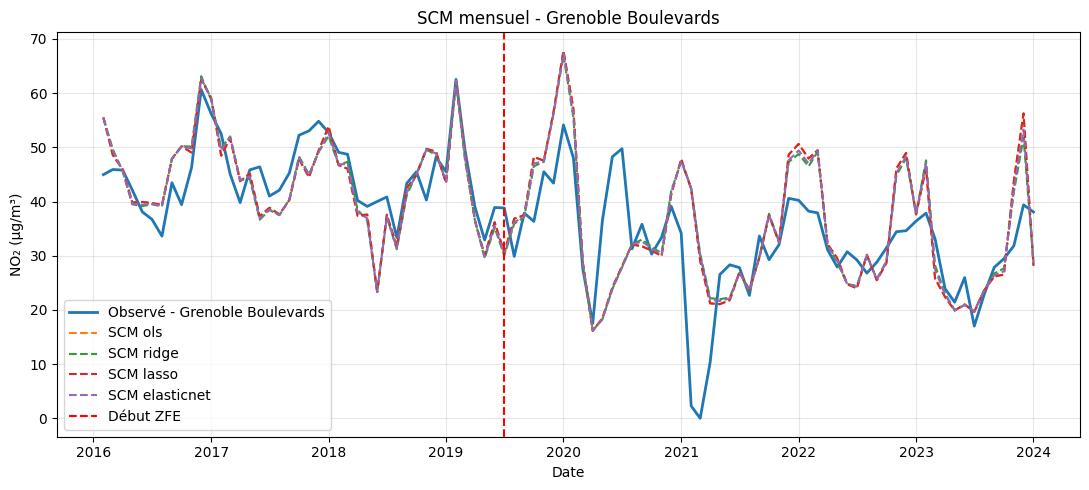

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from scripts.scm_models import fit_penalized_scm_monthly, compute_att_summary

# -------------------
# Grenoble – Boulevards
# -------------------
grenoble_target = pd.read_csv(
    DATA_DIR / "pollution_grenoble_no2_daily_imputed.csv",
    parse_dates=["date"],
)
donors_grenoble = pd.read_csv(
    DATA_DIR / "no2_donors_grenoble_daily_imputed.csv",
    parse_dates=["date"],
)

treated_id_grenoble = "FR15046"  # Grenoble Boulevards
grenoble_start = pd.Timestamp("2019-07-01")  # à adapter si besoin

dates_gre, y_gre, synth_gre, w_gre = fit_penalized_scm_monthly(
    treated_daily=grenoble_target,
    donors_daily=donors_grenoble,
    treated_id=treated_id_grenoble,
    treatment_start=grenoble_start,
)

att_gre = compute_att_summary(
    dates=dates_gre,
    y_treated=y_gre,
    synthetic_dict=synth_gre,
    treatment_start=grenoble_start,
    covid_start=pd.Timestamp("2020-03-01"),
    covid_end=pd.Timestamp("2021-06-30"),
)

print("ATT - Grenoble Boulevards :")
display(att_gre)

plt.figure(figsize=(11, 5))
plt.plot(dates_gre, y_gre, label="Observé - Grenoble Boulevards", linewidth=2)
for key, serie in synth_gre.items():
    plt.plot(dates_gre, serie, linestyle="--", label=f"SCM {key}")
plt.axvline(grenoble_start, color="red", linestyle="--", label="Début ZFE")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.title("SCM mensuel - Grenoble Boulevards")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Début ZFE Paris (mois utilisé pour le SCM) : 2021-06-01
Résumé des ATT (µg/m³) – Paris Champs-Élysées :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,-0.116732,-0.649692,-0.575402
1,Ridge,-0.238565,-2.165638,-2.109415
2,Lasso,-0.261501,-1.479097,-1.404903
3,Elasticnet,-0.242143,-1.631527,-1.563134


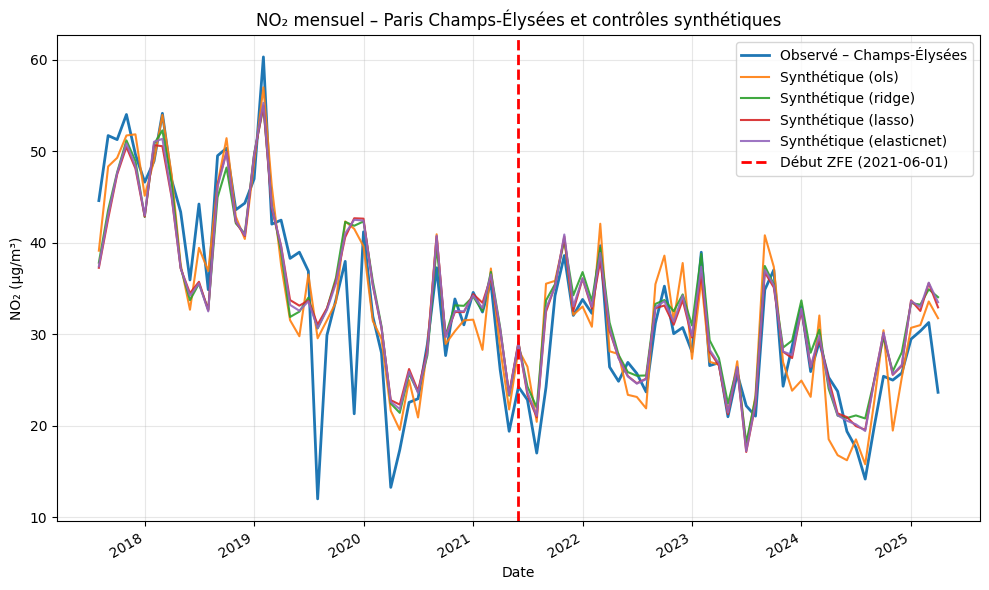

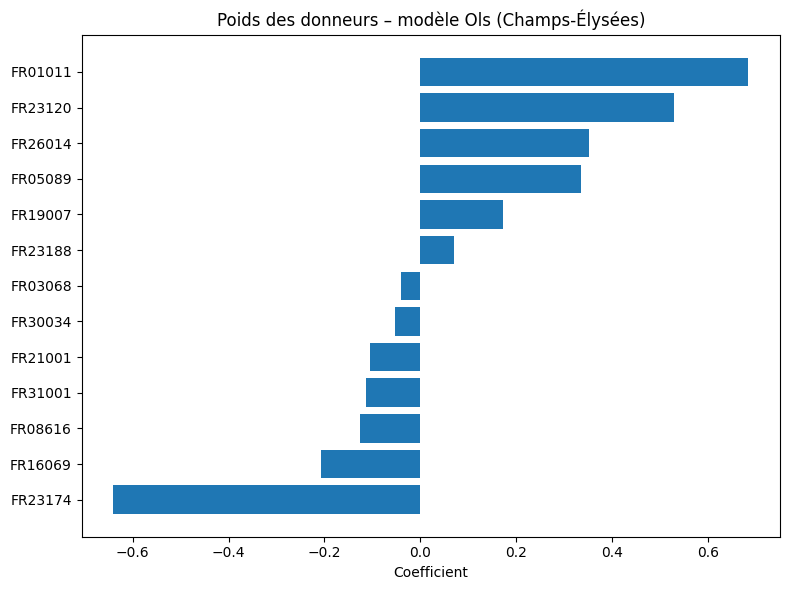

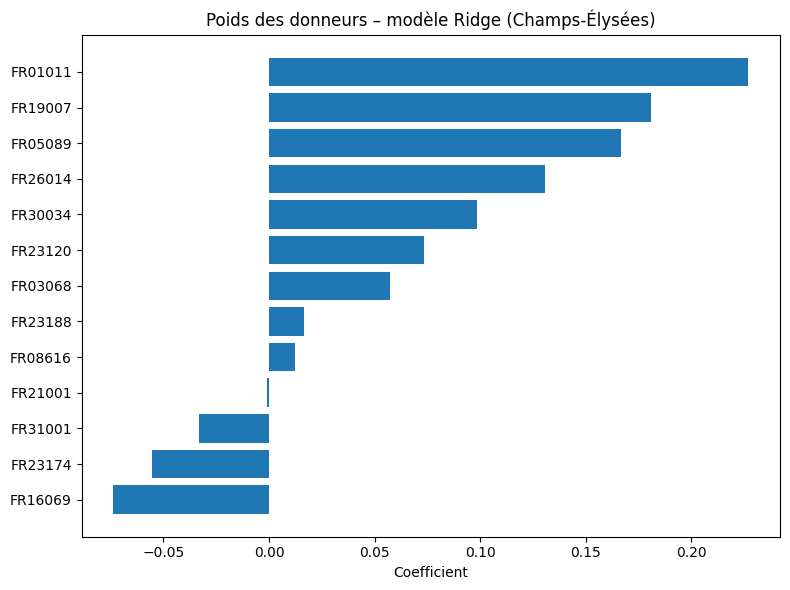

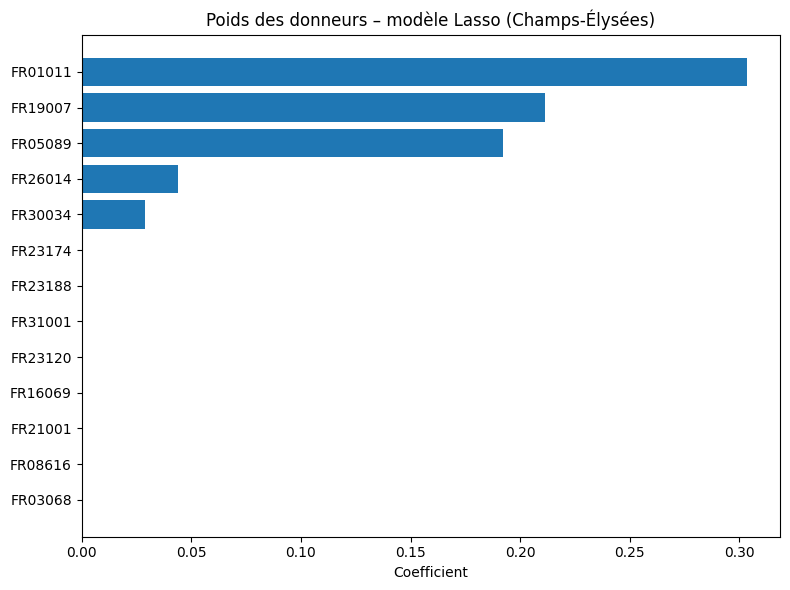

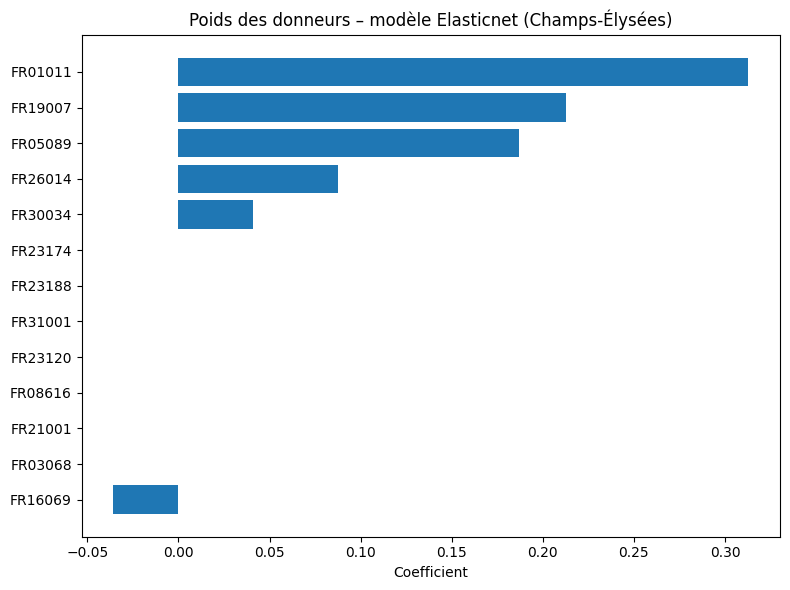

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from scripts.scm_models import fit_penalized_scm_monthly, compute_att_summary

# Dossiers
PROJECT_ROOT = Path().resolve()
DATA_DIR = PROJECT_ROOT / "data"

# Chargement des métadonnées ZFE
zfe_meta = pd.read_csv(DATA_DIR / "zfe_meta.csv")

# Date de début de la ZFE Paris, ramenée au début de mois
paris_start = pd.to_datetime(
    zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "PARIS", "first_date_debut"].iloc[0]
)
paris_start_month = paris_start.to_period("M").to_timestamp()

print("Début ZFE Paris (mois utilisé pour le SCM) :", paris_start_month.date())

# Chargement des séries journalières imputées (station traitée + donneurs)
paris_target = pd.read_csv(DATA_DIR / "pollution_paris_no2_daily_imputed.csv")
donors_paris = pd.read_csv(DATA_DIR / "no2_donors_paris_daily_imputed.csv")

# Identifiant de la station traitée : Champs-Élysées
treated_id_paris = "FR04031"

# Ajustement des SCM pénalisés (Ridge, Lasso, ElasticNet)
dates_paris, y_treated_paris, synthetic_paris, weights_paris = fit_penalized_scm_monthly(
    treated_daily=paris_target,
    donors_daily=donors_paris,
    treated_id=treated_id_paris,
    treatment_start=paris_start_month,
)

# Calcul des ATT moyens (avant / après / après hors Covid)
att_summary_paris = compute_att_summary(
    dates=dates_paris,
    y_treated=y_treated_paris,
    synthetic_dict=synthetic_paris,
    treatment_start=paris_start_month,
    covid_start=pd.Timestamp("2020-03-17"),
    covid_end=pd.Timestamp("2021-06-30"),
)

print("Résumé des ATT (µg/m³) – Paris Champs-Élysées :")
display(att_summary_paris)

# Série temporelle observée vs synthétiques
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dates_paris, y_treated_paris, label="Observé – Champs-Élysées", linewidth=2)

for name, y_syn in synthetic_paris.items():
    ax.plot(dates_paris, y_syn, label=f"Synthétique ({name})", alpha=0.9)

ax.axvline(
    paris_start_month,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Début ZFE ({paris_start_month.date()})",
)

ax.set_title("NO₂ mensuel – Paris Champs-Élysées et contrôles synthétiques")
ax.set_xlabel("Date")
ax.set_ylabel("NO₂ (µg/m³)")
ax.legend()
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Graphiques des poids des donneurs pour chaque modèle
for name, weights in weights_paris.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    weights_sorted = weights.sort_values()
    ax.barh(weights_sorted.index, weights_sorted.values)
    ax.set_title(f"Poids des donneurs – modèle {name.capitalize()} (Champs-Élysées)")
    ax.set_xlabel("Coefficient")
    plt.tight_layout()
    plt.show()


Stations cibles Grenoble :


,station_id,station_name
0,FR15043,Grenoble Les Frenes
2923,FR15046,Grenoble Boulevards


Stations donneuses Grenoble :


,station_id,station_name
0,FR15018,Voiron Urbain
2922,FR15045,Grenoble PeriurbSud
5844,FR15048,Gresivaudan Periurb
8766,FR24038,GAP JEAN JAURES
11688,FR33102,CHAMBERY LE HAUT
14610,FR33111,SAINT JEAN
17532,FR33203,ANNECY Rocade
20454,FR36002,Valence Urb. Centre
23376,FR36019,Romans-sur-Isère


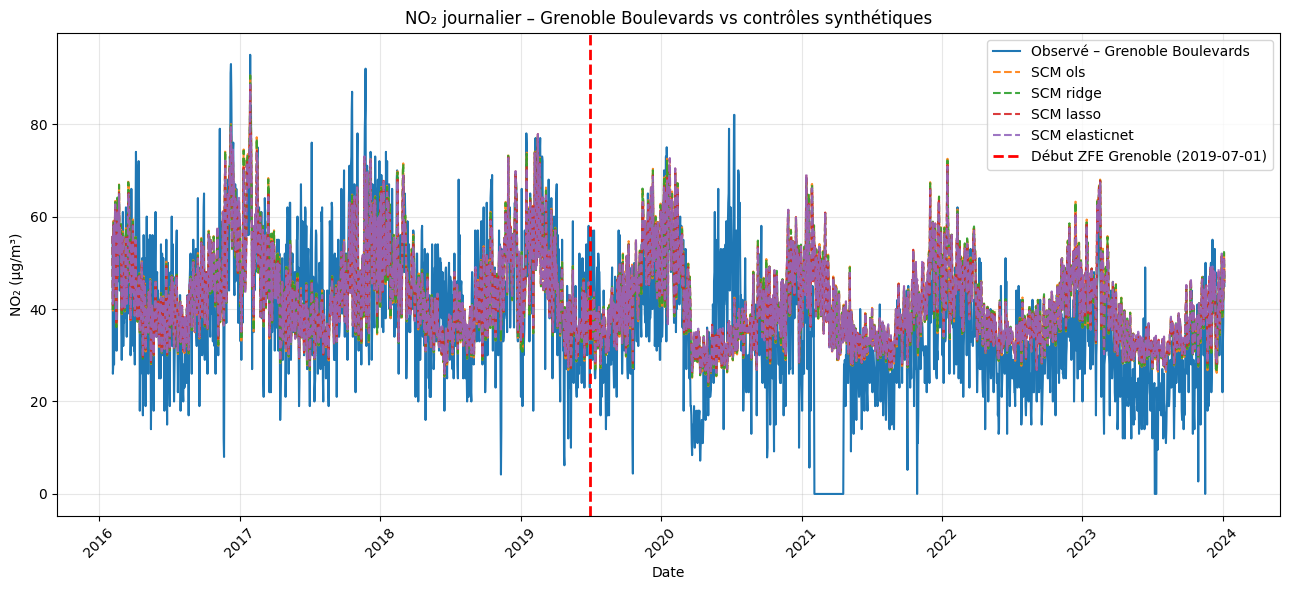

Effets moyens du traitement (ATT) – SCM daily – Grenoble Boulevards


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,2.929129e-15,-8.047899,-7.318587
1,Ridge,3.020665e-15,-8.070807,-7.337718
2,Lasso,4.119088e-16,-8.203218,-7.508140
3,Elasticnet,1.464565e-15,-8.226602,-7.535699


In [15]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from scripts.scm_models import fit_penalized_scm_daily, compute_att_summary

# Dossiers
PROJECT_ROOT = Path().resolve()
DATA_DIR = PROJECT_ROOT / "data"

# -------------------------
# 1. Chargement des données daily imputées
# -------------------------

grenoble_target = pd.read_csv(DATA_DIR / "pollution_grenoble_no2_daily_imputed.csv")
donors_grenoble = pd.read_csv(DATA_DIR / "no2_donors_grenoble_daily_imputed.csv")

grenoble_target["date"] = pd.to_datetime(grenoble_target["date"])
donors_grenoble["date"] = pd.to_datetime(donors_grenoble["date"])

grenoble_target["station_id"] = grenoble_target["station_id"].astype(str).str.strip()
donors_grenoble["station_id"] = donors_grenoble["station_id"].astype(str).str.strip()

print("Stations cibles Grenoble :")
display(grenoble_target[["station_id", "station_name"]].drop_duplicates())

print("Stations donneuses Grenoble :")
display(donors_grenoble[["station_id", "station_name"]].drop_duplicates())

# -------------------------
# 2. SCM daily – Grenoble Boulevards
# -------------------------

treated_id_grenoble = "FR15046"  # Grenoble Boulevards
grenoble_start = pd.Timestamp("2019-07-01")  # début ZFE Grenoble (au jour près)

dates_gre_d, y_gre_d, synth_gre_d, w_gre_d = fit_penalized_scm_daily(
    treated_daily=grenoble_target,
    donors_daily=donors_grenoble,
    treated_id=treated_id_grenoble,
    treatment_start=grenoble_start,
)

# -------------------------
# 3. Graphique série temporelle daily
# -------------------------

plt.figure(figsize=(13, 6))

plt.plot(dates_gre_d, y_gre_d, label="Observé – Grenoble Boulevards", linewidth=1.5)

for name, y_syn in synth_gre_d.items():
    plt.plot(dates_gre_d, y_syn, label=f"SCM {name}", linestyle="--", alpha=0.9)

plt.axvline(grenoble_start, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE Grenoble ({grenoble_start.date()})")

plt.title("NO₂ journalier – Grenoble Boulevards vs contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------
# 4. ATT daily – Grenoble
# -------------------------

covid_start = pd.Timestamp("2020-03-01")
covid_end = pd.Timestamp("2021-06-30")

att_gre_daily = compute_att_summary(
    dates=dates_gre_d,
    y_treated=y_gre_d,
    synthetic_dict=synth_gre_d,
    treatment_start=grenoble_start,
    covid_start=covid_start,
    covid_end=covid_end,
)

print("Effets moyens du traitement (ATT) – SCM daily – Grenoble Boulevards")
display(att_gre_daily)


Stations cibles Paris :


,station_id,station_name
0,FR04031,Av Champs Elysees
3032,FR04055,PARIS 1er Les Halles


Stations donneuses Paris :


,station_id,station_name
0,FR01011,Metz-Centre
2795,FR03068,TOULON FOCH
5590,FR05089,Le Havre Lafaurie-montant
8385,FR08616,Nimes Planas
11180,FR16069,Mulhouse-Briand
13975,FR19007,HALLES
16770,FR21001,Caen Chemin-Vert
19561,FR23120,BEAUX ARTS
22356,FR23174,GUEDOU
25151,FR23188,CIM BOUTEILLERIE


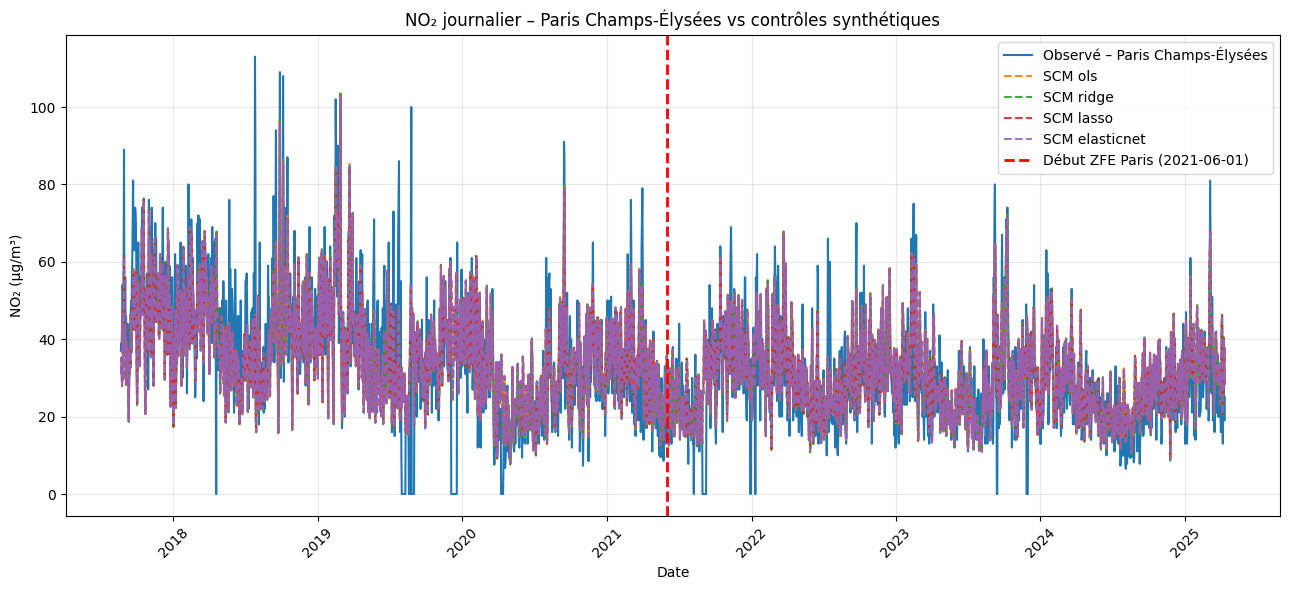

Effets moyens du traitement (ATT) – SCM daily – Paris Champs-Élysées


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,-4.283852e-15,-2.394373,-2.402133
1,Ridge,-2.636217e-15,-2.396069,-2.403833
2,Lasso,-5.931487e-15,-2.469786,-2.476758
3,Elasticnet,-2.306689e-15,-2.454089,-2.461463


In [16]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from scripts.scm_models import fit_penalized_scm_daily, compute_att_summary

# Dossiers
PROJECT_ROOT = Path().resolve()
DATA_DIR = PROJECT_ROOT / "data"

# -------------------------
# 1. Chargement des données daily imputées
# -------------------------

paris_target = pd.read_csv(DATA_DIR / "pollution_paris_no2_daily_imputed.csv")
donors_paris = pd.read_csv(DATA_DIR / "no2_donors_paris_daily_imputed.csv")

paris_target["date"] = pd.to_datetime(paris_target["date"])
donors_paris["date"] = pd.to_datetime(donors_paris["date"])

paris_target["station_id"] = paris_target["station_id"].astype(str).str.strip()
donors_paris["station_id"] = donors_paris["station_id"].astype(str).str.strip()

print("Stations cibles Paris :")
display(paris_target[["station_id", "station_name"]].drop_duplicates())

print("Stations donneuses Paris :")
display(donors_paris[["station_id", "station_name"]].drop_duplicates())

# -------------------------
# 2. SCM daily – Champs-Élysées
# -------------------------

treated_id_paris = "FR04031"  # Av Champs Elysees
paris_start = pd.Timestamp("2021-06-01")  # début ZFE Paris, à adapter si besoin

dates_par_d, y_par_d, synth_par_d, w_par_d = fit_penalized_scm_daily(
    treated_daily=paris_target,
    donors_daily=donors_paris,
    treated_id=treated_id_paris,
    treatment_start=paris_start,
)

# -------------------------
# 3. Graphique série temporelle daily
# -------------------------

plt.figure(figsize=(13, 6))

plt.plot(dates_par_d, y_par_d, label="Observé – Paris Champs-Élysées", linewidth=1.5)

for name, y_syn in synth_par_d.items():
    plt.plot(dates_par_d, y_syn, label=f"SCM {name}", linestyle="--", alpha=0.9)

plt.axvline(paris_start, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE Paris ({paris_start.date()})")

plt.title("NO₂ journalier – Paris Champs-Élysées vs contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------
# 4. ATT daily – Paris
# -------------------------

covid_start = pd.Timestamp("2020-03-01")
covid_end = pd.Timestamp("2021-06-30")

att_par_daily = compute_att_summary(
    dates=dates_par_d,
    y_treated=y_par_d,
    synthetic_dict=synth_par_d,
    treatment_start=paris_start,
    covid_start=covid_start,
    covid_end=covid_end,
)

print("Effets moyens du traitement (ATT) – SCM daily – Paris Champs-Élysées")
display(att_par_daily)


In [17]:
# === Tableaux des donneurs – Paris Champs-Élysées ============================

import pandas as pd
from scripts.scm_models import fit_penalized_scm_monthly, fit_penalized_scm_daily

# 1) Chargement des données journalières imputées
paris_target = pd.read_csv(
    DATA_DIR / "pollution_paris_no2_daily_imputed.csv",
    parse_dates=["date"],
)

donors_paris = pd.read_csv(
    DATA_DIR / "no2_donors_paris_daily_imputed.csv",
    parse_dates=["date"],
)

# Harmoniser le type de station_id
for df in (paris_target, donors_paris):
    df["station_id"] = df["station_id"].astype(str).str.strip()

# 2) Paramètres pour Paris Champs-Élysées
treated_id_par = "FR04031"                 # Champs-Élysées
zfe_start_par = pd.Timestamp("2021-06-01") # début ZFE Paris

# 3) SCM mensuel (si pas déjà calculé dans le notebook)
dates_m_par, y_m_par, synth_m_par, w_m_par = fit_penalized_scm_monthly(
    treated_daily=paris_target,
    donors_daily=donors_paris,
    treated_id=treated_id_par,
    treatment_start=zfe_start_par,
)

# 4) Tableaux de poids des donneurs – mensuel
weights_tables_m_par = make_weights_tables(w_m_par, donors_paris)

for method, df in weights_tables_m_par.items():
    print(f"\nPoids des donneurs – SCM mensuel – Paris Champs-Élysées – méthode {method.capitalize()}")
    display(df)

# 5) (optionnel) SCM daily + tableaux de poids
dates_d_par, y_d_par, synth_d_par, w_d_par = fit_penalized_scm_daily(
    treated_daily=paris_target,
    donors_daily=donors_paris,
    treated_id=treated_id_par,
    treatment_start=zfe_start_par,
)

weights_tables_d_par = make_weights_tables(w_d_par, donors_paris)

for method, df in weights_tables_d_par.items():
    print(f"\nPoids des donneurs – SCM daily – Paris Champs-Élysées – méthode {method.capitalize()}")
    display(df)



Poids des donneurs – SCM mensuel – Paris Champs-Élysées – méthode Ols


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.684239
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.530003
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.352015
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.335118
5,FR19007,HALLES,Urbaine,Trafic,0.171655
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,0.070780
1,FR03068,TOULON FOCH,Urbaine,Trafic,-0.040867
11,FR30034,Nancy-Charles III,Urbaine,Fond,-0.053323
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,-0.105810
12,FR31001,GRAND PARC,Urbaine,Fond,-0.113698



Poids des donneurs – SCM mensuel – Paris Champs-Élysées – méthode Ridge


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.226946
5,FR19007,HALLES,Urbaine,Trafic,0.180808
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.166830
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.130620
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.098370
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.073547
1,FR03068,TOULON FOCH,Urbaine,Trafic,0.057258
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,0.016781
3,FR08616,Nimes Planas,Urbaine,Trafic,0.012480
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,-0.001135



Poids des donneurs – SCM mensuel – Paris Champs-Élysées – méthode Lasso


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.303321
5,FR19007,HALLES,Urbaine,Trafic,0.211371
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.192353
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.044087
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.029113
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,-0.000000
3,FR08616,Nimes Planas,Urbaine,Trafic,0.000000
1,FR03068,TOULON FOCH,Urbaine,Trafic,0.000000
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,0.000000
8,FR23174,GUEDOU,Urbaine,Fond,-0.000000



Poids des donneurs – SCM mensuel – Paris Champs-Élysées – méthode Elasticnet


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.312782
5,FR19007,HALLES,Urbaine,Trafic,0.212734
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.186875
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.087524
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.041035
8,FR23174,GUEDOU,Urbaine,Fond,-0.000000
3,FR08616,Nimes Planas,Urbaine,Trafic,0.000000
1,FR03068,TOULON FOCH,Urbaine,Trafic,0.000000
6,FR21001,Caen Chemin-Vert,Urbaine,Fond,-0.000000
9,FR23188,CIM BOUTEILLERIE,Urbaine,Fond,0.000000



Poids des donneurs – SCM daily – Paris Champs-Élysées – méthode Ols


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.148112
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.123073
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.120558
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.105345
5,FR19007,HALLES,Urbaine,Trafic,0.096377
8,FR23174,GUEDOU,Urbaine,Fond,0.085081
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.055905
3,FR08616,Nimes Planas,Urbaine,Trafic,0.051149
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,0.022938
12,FR31001,GRAND PARC,Urbaine,Fond,0.022370



Poids des donneurs – SCM daily – Paris Champs-Élysées – méthode Ridge


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.147729
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.122965
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.120397
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.105107
5,FR19007,HALLES,Urbaine,Trafic,0.096286
8,FR23174,GUEDOU,Urbaine,Fond,0.084497
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.055884
3,FR08616,Nimes Planas,Urbaine,Trafic,0.051093
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,0.023189
12,FR31001,GRAND PARC,Urbaine,Fond,0.022424



Poids des donneurs – SCM daily – Paris Champs-Élysées – méthode Lasso


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.145177
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.121260
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.119008
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.104864
5,FR19007,HALLES,Urbaine,Trafic,0.095444
8,FR23174,GUEDOU,Urbaine,Fond,0.074543
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.054144
3,FR08616,Nimes Planas,Urbaine,Trafic,0.049885
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,0.024517
12,FR31001,GRAND PARC,Urbaine,Fond,0.020260



Poids des donneurs – SCM daily – Paris Champs-Élysées – méthode Elasticnet


,station_id,station_name,station_env,station_influence,poids
0,FR01011,Metz-Centre,Urbaine,Fond,0.142226
11,FR30034,Nancy-Charles III,Urbaine,Fond,0.120703
2,FR05089,Le Havre Lafaurie-montant,Urbaine,Trafic,0.118006
10,FR26014,Dijon Trémouille,Urbaine,Fond,0.102252
5,FR19007,HALLES,Urbaine,Trafic,0.094832
8,FR23174,GUEDOU,Urbaine,Fond,0.074194
7,FR23120,BEAUX ARTS,Urbaine,Fond,0.054663
3,FR08616,Nimes Planas,Urbaine,Trafic,0.049886
4,FR16069,Mulhouse-Briand,Urbaine,Trafic,0.026603
12,FR31001,GRAND PARC,Urbaine,Fond,0.021993


In [18]:
import pandas as pd

# Métadonnées des donneurs de Grenoble (une ligne par station)
donors_meta_gre = (
    donors_grenoble
    .groupby("station_id", as_index=False)[["station_name", "station_env", "station_influence"]]
    .first()
)

def show_weights_table(weights_dict: dict, meta_df: pd.DataFrame, method_name: str) -> None:
    """
    Construit et affiche le tableau des donneurs pour une méthode donnée.

    weights_dict : dict[str, pd.Series]
        Dictionnaire {méthode -> série de poids} renvoyé par fit_penalized_scm_*.
    meta_df : DataFrame
        Métadonnées des donneurs (station_id, nom, type d'implantation, type d'influence).
    method_name : str
        "ols", "ridge", "lasso" ou "elasticnet".
    """
    if method_name not in weights_dict:
        raise ValueError(f"Aucun poids trouvé pour la méthode '{method_name}'.")

    # Série de poids pour la méthode choisie
    weights = weights_dict[method_name].rename("poids")

    # Jointure avec les métadonnées
    df = meta_df.merge(
        weights,
        left_on="station_id",
        right_index=True,
        how="left",
    )

    # Tri par poids absolu décroissant pour mieux voir les donneurs importants
    df["poids_abs"] = df["poids"].abs()
    df = df.sort_values("poids_abs", ascending=False).drop(columns="poids_abs")

    print(f"Poids des donneurs – Grenoble Boulevards – méthode {method_name}")
    display(df)


# Affichage d'un tableau par méthode
for method in ["ols", "ridge", "lasso", "elasticnet"]:
    show_weights_table(w_gre, donors_meta_gre, method)


Poids des donneurs – Grenoble Boulevards – méthode ols


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.588996
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.226782
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.926671
5,FR33111,SAINT JEAN,Urbaine,Fond,0.817279
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.731100
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.598832
0,FR15018,Voiron Urbain,Urbaine,Fond,0.586867
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.241939
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.065617


Poids des donneurs – Grenoble Boulevards – méthode ridge


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.400121
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.065883
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.700016
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.660700
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.560798
5,FR33111,SAINT JEAN,Urbaine,Fond,0.532325
0,FR15018,Voiron Urbain,Urbaine,Fond,0.526323
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.315025
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.050592


Poids des donneurs – Grenoble Boulevards – méthode lasso


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.588740
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.226471
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.926172
5,FR33111,SAINT JEAN,Urbaine,Fond,0.816544
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.731017
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.598727
0,FR15018,Voiron Urbain,Urbaine,Fond,0.586659
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.241978
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.065146


Poids des donneurs – Grenoble Boulevards – méthode elasticnet


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.474337
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.124126
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.749500
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.709310
5,FR33111,SAINT JEAN,Urbaine,Fond,0.617688
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.572702
0,FR15018,Voiron Urbain,Urbaine,Fond,0.543556
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.281191
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.028392


<a id="scm-grenoble"></a> 
### Résultats pour Grenoble – station *Grenoble Boulevards* (SCM mensuel et daily)

Dans cette section, on se concentre sur la station de trafic **Grenoble Boulevards** (*FR15046*), située au cœur de la ZFE. La station de fond *Les Frênes* a été traitée de manière symétrique, mais pour ne pas alourdir le rapport nous documentons en détail uniquement Boulevards (et, côté parisien, les Champs-Élysées).

L’idée est de comparer, à chaque date \(t\), la concentration observée à Boulevards \(Y_t^{\text{traité}}\) à celle d’un **contrôle synthétique** \(Y_t^{\text{synth}}\) construit comme combinaison linéaire des stations donneuses (Voiron, Valence, Chambéry, Annecy, Romans-sur-Isère, etc.).  

On résume ensuite la différence par l’**effet moyen du traitement (ATT)** :
\[
\text{ATT}_t = Y_t^{\text{traité}} - Y_t^{\text{synth}}.
\]

Un ATT proche de zéro avant l’introduction de la ZFE signifie que le contrefactuel reproduit correctement la station traitée. Après la mise en place de la ZFE : un **ATT négatif** indique que la station traitée est en moyenne en dessous de son contrôle synthétique, donc que le NO₂ mesuré est plus faible que ce que l’on aurait attendu en l’absence de ZFE et un **ATT positif** indiquerait au contraire des niveaux plus élevés que le contrefactuel.

Nous commençeons par le modèle **mensuel**, puis on réplique l’analyse **au pas journalier** pour vérifier que les conclusions ne dépendent pas uniquement de l’agrégation.

### SCM mensuel – Grenoble Boulevards


ATT (µg/m³) – SCM mensuel – Grenoble Boulevards :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,0.509018,-2.422083,-3.062118
1,Ridge,0.613582,-2.288667,-2.732374
2,Lasso,0.509223,-2.421357,-3.060887
3,Elasticnet,0.576078,-2.310791,-2.813359


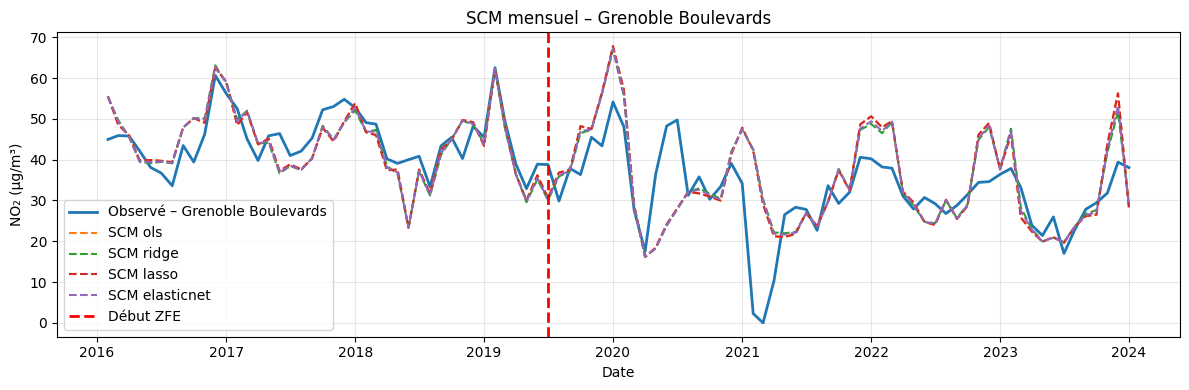


Poids des donneurs – SCM mensuel – méthode Ols


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.588996
5,FR33111,SAINT JEAN,Urbaine,Fond,0.817279
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.731100
0,FR15018,Voiron Urbain,Urbaine,Fond,0.586867
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.241939
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.065617
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.598832
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.926671
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.226782



Poids des donneurs – SCM mensuel – méthode Ridge


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.400121
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.700016
5,FR33111,SAINT JEAN,Urbaine,Fond,0.532325
0,FR15018,Voiron Urbain,Urbaine,Fond,0.526323
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.315025
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.050592
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.560798
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.660700
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.065883



Poids des donneurs – SCM mensuel – méthode Lasso


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.588740
5,FR33111,SAINT JEAN,Urbaine,Fond,0.816544
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.731017
0,FR15018,Voiron Urbain,Urbaine,Fond,0.586659
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.241978
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.065146
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.598727
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.926172
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.226471



Poids des donneurs – SCM mensuel – méthode Elasticnet


,station_id,station_name,station_env,station_influence,poids
7,FR36002,Valence Urb. Centre,Urbaine,Fond,1.474337
6,FR33203,ANNECY Rocade,Urbaine,Trafic,0.709310
5,FR33111,SAINT JEAN,Urbaine,Fond,0.617688
0,FR15018,Voiron Urbain,Urbaine,Fond,0.543556
3,FR24038,GAP JEAN JAURES,Urbaine,Trafic,0.281191
1,FR15045,Grenoble PeriurbSud,Périurbaine,Fond,-0.028392
8,FR36019,Romans-sur-Isère,Urbaine,Fond,-0.572702
2,FR15048,Gresivaudan Periurb,Périurbaine,Fond,-0.749500
4,FR33102,CHAMBERY LE HAUT,Urbaine,Fond,-1.124126


In [19]:
# SCM mensuel – Grenoble Boulevards 

import pandas as pd
import matplotlib.pyplot as plt

# 1) Charger les données journalières imputées (cible + donneurs)
grenoble_target = pd.read_csv(
    DATA_DIR / "pollution_grenoble_no2_daily_imputed.csv",
    parse_dates=["date"],
)

donors_grenoble = pd.read_csv(
    DATA_DIR / "no2_donors_grenoble_daily_imputed.csv",
    parse_dates=["date"],
)


# Paramètres SCM
treated_id_gre = "FR15046"                  # Grenoble Boulevards
zfe_start_gre = pd.Timestamp("2019-07-01")  # début de la ZFE Grenoble (au mois près)

# Ajustement SCM mensuel (OLS, Ridge, Lasso, ElasticNet)
dates_m_gre, y_m_gre, synth_m_gre, w_m_gre = fit_penalized_scm_monthly(
    treated_daily=grenoble_target,
    donors_daily=donors_grenoble,
    treated_id=treated_id_gre,
    treatment_start=zfe_start_gre,
)

# Résumé des ATT mensuels (pré / post / post hors Covid)
att_m_gre = compute_att_summary(
    dates=dates_m_gre,
    y_treated=y_m_gre,
    synthetic_dict=synth_m_gre,
    treatment_start=zfe_start_gre,
    covid_start=pd.Timestamp("2020-03-01"),
    covid_end=pd.Timestamp("2021-06-30"),
)

print("ATT (µg/m³) – SCM mensuel – Grenoble Boulevards :")
display(att_m_gre)

# Graphique SCM mensuel
plt.figure(figsize=(12, 4))
plt.plot(dates_m_gre, y_m_gre, label="Observé – Grenoble Boulevards", linewidth=2)

for method, y_syn in synth_m_gre.items():
    plt.plot(y_syn.index, y_syn.values, "--", label=f"SCM {method}")

plt.axvline(zfe_start_gre, color="red", linestyle="--", linewidth=2, label="Début ZFE")
plt.title("SCM mensuel – Grenoble Boulevards")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tableau des poids des donneurs (mensuel) pour chaque méthode

weights_tables_m_gre = make_weights_tables(w_m_gre, donors_grenoble)

for method, df in weights_tables_m_gre.items():
    print(f"\nPoids des donneurs – SCM mensuel – méthode {method.capitalize()}")
    display(df)



Avant la mise en place de la ZFE (jusqu’à mi-2019), les séries synthétiques mensuelles (OLS, Ridge, Lasso, ElasticNet) suivent très bien la trajectoire de **Grenoble Boulevards**. Les ATT moyens pré-traitement sont légèrement positifs (environ +0,5–0,6 µg/m³), ce qui signifie que la station réelle est, en moyenne, très légèrement au-dessus de son contrôle synthétique mais que l’écart reste faible. C’est exactement ce que l’on attend d’un bon SCM : un contrefactuel qui colle au mieux à l’unité traitée avant l’intervention.

Les tableaux de poids donnent un éclairage utile sur la composition du contrôle synthétique :

- **Valence Urbain Centre (FR36002)** apparaît comme donneur principal, avec un poids supérieur à 1 dans tous les modèles. Son profil urbain de fond et son exposition au trafic régional sont cohérents avec ceux de Grenoble.
- **Chambéry le Haut (FR33102)** et **Gresivaudan Périurbain (FR15048)** portent des poids négatifs importants. Elles servent à ajuster le niveau de la combinaison lorsque ces stations présentent des concentrations systématiquement plus élevées que Boulevards.
- **Annecy Rocade (FR33203)**, **Saint-Jean (FR33111)**, **Voiron Urbain (FR15018)** et **Gap Jean-Jaurès (FR24038)** complètent le mélange avec des poids positifs modérés.
- **Grenoble PériurbSud (FR15045)** et **Romans-sur-Isère (FR36019)** reçoivent des poids proches de zéro dans les versions pénalisées, ce qui suggère qu’elles n’apportent pas d’information décisive une fois les autres donneurs pris en compte.

La structure des poids est remarquablement stable d’un modèle à l’autre : les versions pénalisées (Ridge, Lasso, ElasticNet) ne bouleversent pas la combinaison mais resserrent les coefficients les plus extrêmes. Cela plaide pour une certaine robustesse du contrefactuel.

Après juillet 2019, plusieurs éléments ressortent :

- La période **Covid 2020-2021** se traduit par un effondrement brutal des niveaux de NO₂, visible à la fois sur la station traitée, mais pas totalement sur les donneurs. Comme ce choc est national, nous regardons également sans ces mois dans le calcul de l’ATT « post sans Covid » afin voir l'effet de retirer cette période à la ZFE et exclure les baisses clairement liées aux confinements et aux restrictions de mobilité.
- Une fois cette fenêtre retirée, les **ATT moyens post-traitement** sont **négatifs** et se situent entre environ –2,3 et –3,1 µg/m³ selon la méthode. Rapporté à un niveau moyen de 35–40 µg/m³ avant la ZFE, cela correspond à une diminution de l’ordre de 6 à 9 % par rapport au contrefactuel.

Il serait excessif d’en conclure que la ZFE explique seule cette baisse. D’autres facteurs interviennent : renforcement progressif des normes Euro et renouvellement du parc automobile, développement des transports collectifs et des mobilités alternatives, éventuelle réorganisation du trafic, conditions météorologiques sur certaines années, etc. Néanmoins, le fait que Grenoble Boulevards passe durablement en dessous de son contrôle synthétique, alors que l’ajustement pré-ZFE est très bon, est cohérent avec l’hypothèse d’un **effet additionnel** de la ZFE sur les niveaux de NO₂.

### SCM daily – Grenoble Boulevards

ATT (µg/m³) – SCM daily – Grenoble Boulevards :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ols,2.929129e-15,-8.047899,-7.318587
1,Ridge,3.020665e-15,-8.070807,-7.337718
2,Lasso,4.119088e-16,-8.203218,-7.508140
3,Elasticnet,1.464565e-15,-8.226602,-7.535699


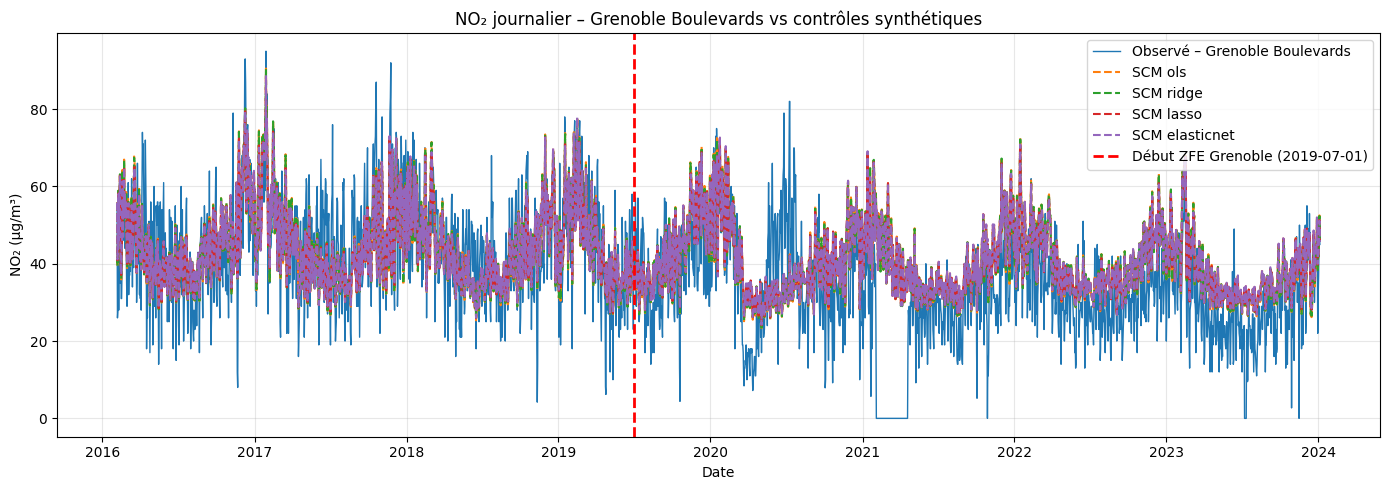

In [20]:
# === SCM daily – Grenoble Boulevards =========================================

# On réutilise grenoble_target et donors_grenoble chargés dans la cellule précédente.

# Ajustement SCM daily (OLS, Ridge, Lasso, ElasticNet)
dates_d_gre, y_d_gre, synth_d_gre, w_d_gre = fit_penalized_scm_daily(
    treated_daily=grenoble_target,
    donors_daily=donors_grenoble,
    treated_id=treated_id_gre,
    treatment_start=zfe_start_gre,
)

# Résumé des ATT journaliers (pré / post / post hors Covid)
att_d_gre = compute_att_summary(
    dates=dates_d_gre,
    y_treated=y_d_gre,
    synthetic_dict=synth_d_gre,
    treatment_start=zfe_start_gre,
    covid_start=pd.Timestamp("2020-03-01"),
    covid_end=pd.Timestamp("2021-06-30"),
)

print("ATT (µg/m³) – SCM daily – Grenoble Boulevards :")
display(att_d_gre)

# Graphique SCM daily
plt.figure(figsize=(14, 5))
plt.plot(dates_d_gre, y_d_gre, label="Observé – Grenoble Boulevards", linewidth=1)

for method, y_syn in synth_d_gre.items():
    plt.plot(y_syn.index, y_syn.values, "--", label=f"SCM {method}")

plt.axvline(zfe_start_gre, color="red", linestyle="--", linewidth=2,
            label="Début ZFE Grenoble (2019-07-01)")
plt.title("NO₂ journalier – Grenoble Boulevards vs contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Pour tester la sensibilité des résultats à l’agrégation temporelle, on applique ensuite exactement la même démarche au **pas journalier**, en utilisant les séries imputées jour par jour pour la station traitée et pour les donneurs.

À cette échelle, on voit beaucoup mieux la structure fine de la pollution : alternance saisonnière hiver/été, épisodes aigus en hiver et lors de conditions anticycloniques stables, creux estivaux, etc. Les trajectoires synthétiques restent néanmoins très proches de la série observée, y compris jour par jour puisque : 

- en **pré-traitement**, les ATT moyens sont quasiment nuls (les valeurs sont de l’ordre de 10⁻¹⁵ en µg/m³, c’est-à-dire zéro à la précision numérique près), ce qui confirme la qualité du contrôle synthétique ;
- en **post-traitement**, les ATT journaliers tournent autour de –8 µg/m³, et entre environ –7,3 et –7,5 µg/m³ si fois la période Covid exclue.

Compte tenu d’un niveau moyen de NO₂ à Boulevards autour de 35–40 µg/m³, cela correspond à une baisse d’environ 15 à 20 % par rapport au contrefactuel quotidien. Le signal est donc plus marqué qu’en mensuel. En effet, l’agrégation au mois tend à lisser les épisodes où la station traitée diverge nettement de ses donneurs, ce qui réduit mécaniquement l’ATT moyen.

Au final, les SCM mensuel et daily racontent la même histoire. Le contrôle synthétique reproduit très bien la station traitée avant l’introduction de la ZFE. Après 2019, **Grenoble Boulevards** se situe en moyenne en dessous de son contrôle synthétique, avec une baisse modérée mais nette au pas mensuel (≈ 6–9 %) et une baisse plus marquée au pas journalier (≈ 15–20 %).

Les résultats sont stables entre OLS, Ridge, Lasso et ElasticNet et robustes au retrait de la période Covid. Ils ne démontrent pas que la ZFE est l’unique cause de la baisse du NO₂, mais ils sont compatibles avec l’idée que la ZFE contribue à accélérer la diminution des concentrations sur cette station de trafic. Dans la suite du rapport, on applique la même démarche à la station parisienne des **Champs-Élysées**, ce qui permettra de comparer les ordres de grandeur obtenus entre une agglomération de taille moyenne (Grenoble) et une métropole beaucoup plus dense (Paris).